#### Importing the required libraries and the dataset

In [1]:
import math
import pandas as pd
import numpy as np
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import seaborn as sns
import pmdarima as pm
import tensorflow as tf
from scipy import stats
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Conv1D, MaxPooling1D, Flatten, GRU, SimpleRNN
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import RMSprop, Adam
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import RandomizedSearchCV

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load the dataset
df = pd.read_csv('RELIANCE_STOCK (1).csv')

# View the first few rows of the dataset
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-01-03,36.747459,38.944569,36.747459,38.944569,29.684193,28802010.0
1,2000-01-04,39.981236,42.062302,38.882679,42.062302,32.060585,61320457.0
2,2000-01-05,39.710464,44.545658,39.710464,43.710136,33.316597,173426953.0
3,2000-01-06,44.715855,46.526150,44.715855,45.543640,34.714115,101355113.0
4,2000-01-07,45.644211,49.187443,45.334759,48.669109,37.096405,128426756.0


#### Understanding the dataset

1.   Date = stocks status at the date
2.   symbol = stocks name
3.   prev close = previous days close price
4.   open = open price for current day
5.   high = price made high for current day
6.   low = price made low of current day
7.   last = last trade price in day
8.   close = close price day
9.   vwap = volume weighted average price
10.  volume (lacs)= traded volume
11.  turnover = turnover
12.  trades= number of trades
13.  deliverable volume= amount of deliverabe volume

In [3]:
# Examine the structure of the dataset
print("Dataset Shape:", df.shape)

Dataset Shape: (5755, 7)


In [4]:
# Get list of columns from the dataset
print("Columns:", df.columns)

Columns: Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')


In [5]:
# Get the data types for all the columns
print("Data Types:\n", df.dtypes)

Data Types:
 Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume       float64
dtype: object


### Data Preprocessing

#### Parse the 'Date' column as datetime

In [6]:
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')

# Display the dataframe after parsing the date column
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-01-03,36.747459,38.944569,36.747459,38.944569,29.684193,28802010.0
1,2000-01-04,39.981236,42.062302,38.882679,42.062302,32.060585,61320457.0
2,2000-01-05,39.710464,44.545658,39.710464,43.710136,33.316597,173426953.0
3,2000-01-06,44.715855,46.526150,44.715855,45.543640,34.714115,101355113.0
4,2000-01-07,45.644211,49.187443,45.334759,48.669109,37.096405,128426756.0


Now, 'df' contains the dataset with the 'date' column parsed as datetime objects.

In [7]:
# Set 'date' column as index
df.set_index('Date', inplace=True)
df.index=pd.to_datetime(df.index)
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-03,36.747459,38.944569,36.747459,38.944569,29.684193,28802010.0
2000-01-04,39.981236,42.062302,38.882679,42.062302,32.060585,61320457.0
2000-01-05,39.710464,44.545658,39.710464,43.710136,33.316597,173426953.0
2000-01-06,44.715855,46.526150,44.715855,45.543640,34.714115,101355113.0
2000-01-07,45.644211,49.187443,45.334759,48.669109,37.096405,128426756.0
...,...,...,...,...,...,...
2022-12-26,2514.750000,2542.000000,2492.399902,2524.050049,2524.050049,2764496.0
2022-12-27,2530.000000,2548.800049,2515.250000,2544.699951,2544.699951,2659749.0
2022-12-28,2538.000000,2549.800049,2521.500000,2544.449951,2544.449951,3442509.0


#### Handling Missing Values

In [8]:
# Check for null values
df.isnull().sum().sort_values(ascending=False)

Open         10
High         10
Low          10
Close        10
Adj Close    10
Volume       10
dtype: int64

We can see that there are 10 null values in all the columns. As these are all numerical columns, we will impute these using mean.

In [9]:
# Imputation using mean for numerical columns
for col in df.select_dtypes(include=['number']).columns:
    df[col].fillna(df[col].mean(), inplace=True)

In [10]:
# Check for null values again to confirm if all have been taken care of
df.isnull().sum().sort_values(ascending=False)

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

All the null values have been handled.

In [11]:
# Summarize the data
print("\nSummary Statistics:")
df.describe(include='all')  # Include all columns in summary


Summary Statistics:


,Open,High,Low,Close,Adj Close,Volume
count,5755.000000,5755.000000,5755.000000,5755.000000,5755.000000,5.755000e+03
mean,638.461095,646.283828,630.097175,637.879417,615.592615,1.681692e+07
std,679.144366,686.600592,671.322910,678.651774,681.558452,1.808354e+07
min,31.796223,33.962387,30.504259,31.440351,23.964357,0.000000e+00
25%,103.124977,104.273815,102.065102,102.993458,90.613037,6.342405e+06
50%,447.433777,451.222870,441.316772,446.789886,418.954376,1.017652e+07
75%,681.044373,689.563599,667.733062,674.091522,636.486511,2.032690e+07
max,2856.149902,2856.149902,2786.100098,2819.850098,2811.385742,2.918015e+08


### Data Visualizations

Text(0.5, 1.0, 'Low')

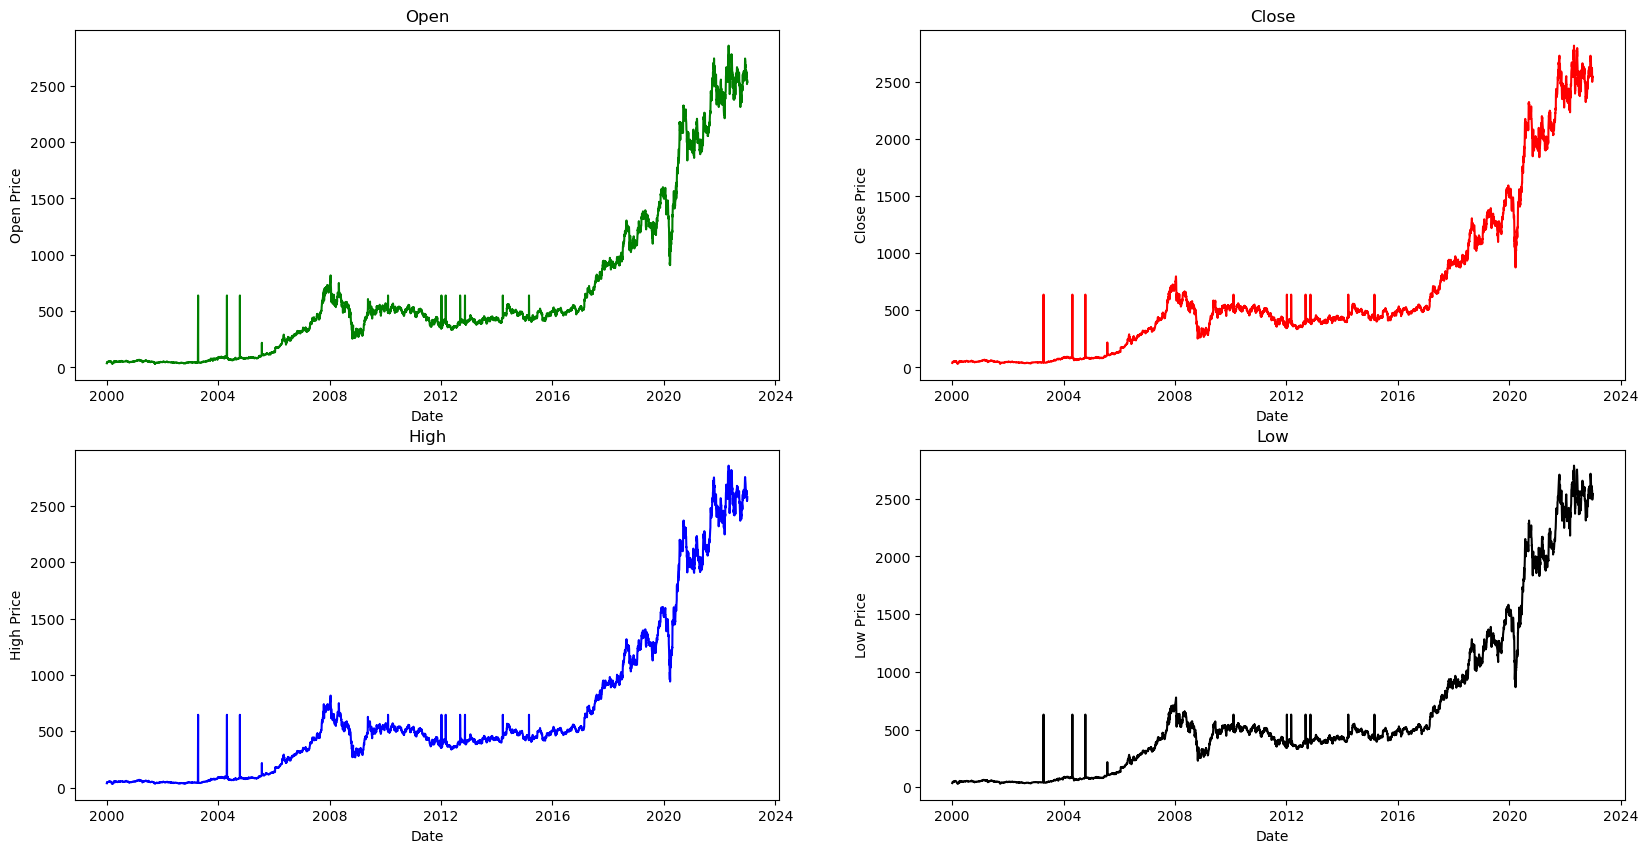

In [12]:
# Visualizing the trend of all the columns

plt.figure(figsize=(20,10))
#Plot 1
plt.subplot(2,2,1)
plt.plot(df['Open'],color='green')
plt.xlabel('Date')
plt.ylabel('Open Price')
plt.title('Open')
#Plot 2
plt.subplot(2,2,2)
plt.plot(df['Close'],color='red')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Close')
#Plot 3
plt.subplot(2,2,3)
plt.plot(df['High'],color='blue')
plt.xlabel('Date')
plt.ylabel('High Price')
plt.title('High')
#Plot 4
plt.subplot(2,2,4)
plt.plot(df['Low'],color='black')
plt.xlabel('Date')
plt.ylabel('Low Price')
plt.title('Low')

Text(0.5, 1.0, 'Low')

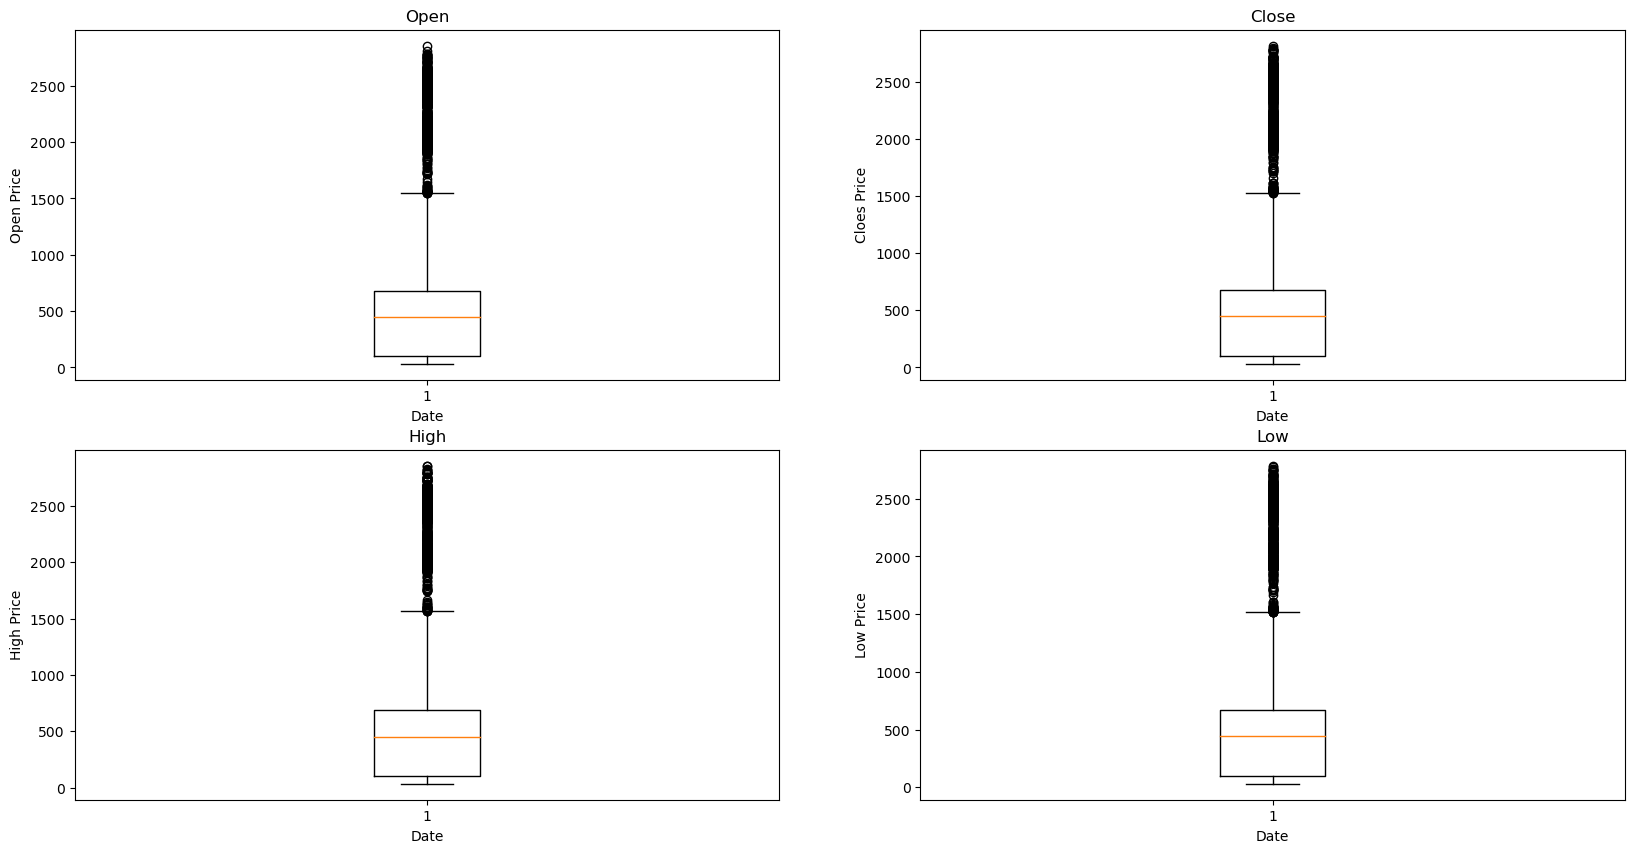

In [13]:
# Visualizing the trend of all the columns as box-plots

plt.figure(figsize=(20,10))
#Plot 1
plt.subplot(2,2,1)
plt.boxplot(df['Open'])
plt.xlabel('Date')
plt.ylabel('Open Price')
plt.title('Open')
#Plot 2
plt.subplot(2,2,2)
plt.boxplot(df['Close'])
plt.xlabel('Date')
plt.ylabel('Cloes Price')
plt.title('Close')
#Plot 3
plt.subplot(2,2,3)
plt.boxplot(df['High'])
plt.xlabel('Date')
plt.ylabel('High Price')
plt.title('High')
#Plot 4
plt.subplot(2,2,4)
plt.boxplot(df['Low'])
plt.xlabel('Date')
plt.ylabel('Low Price')
plt.title('Low')

Text(0.5, 1.0, 'Low')

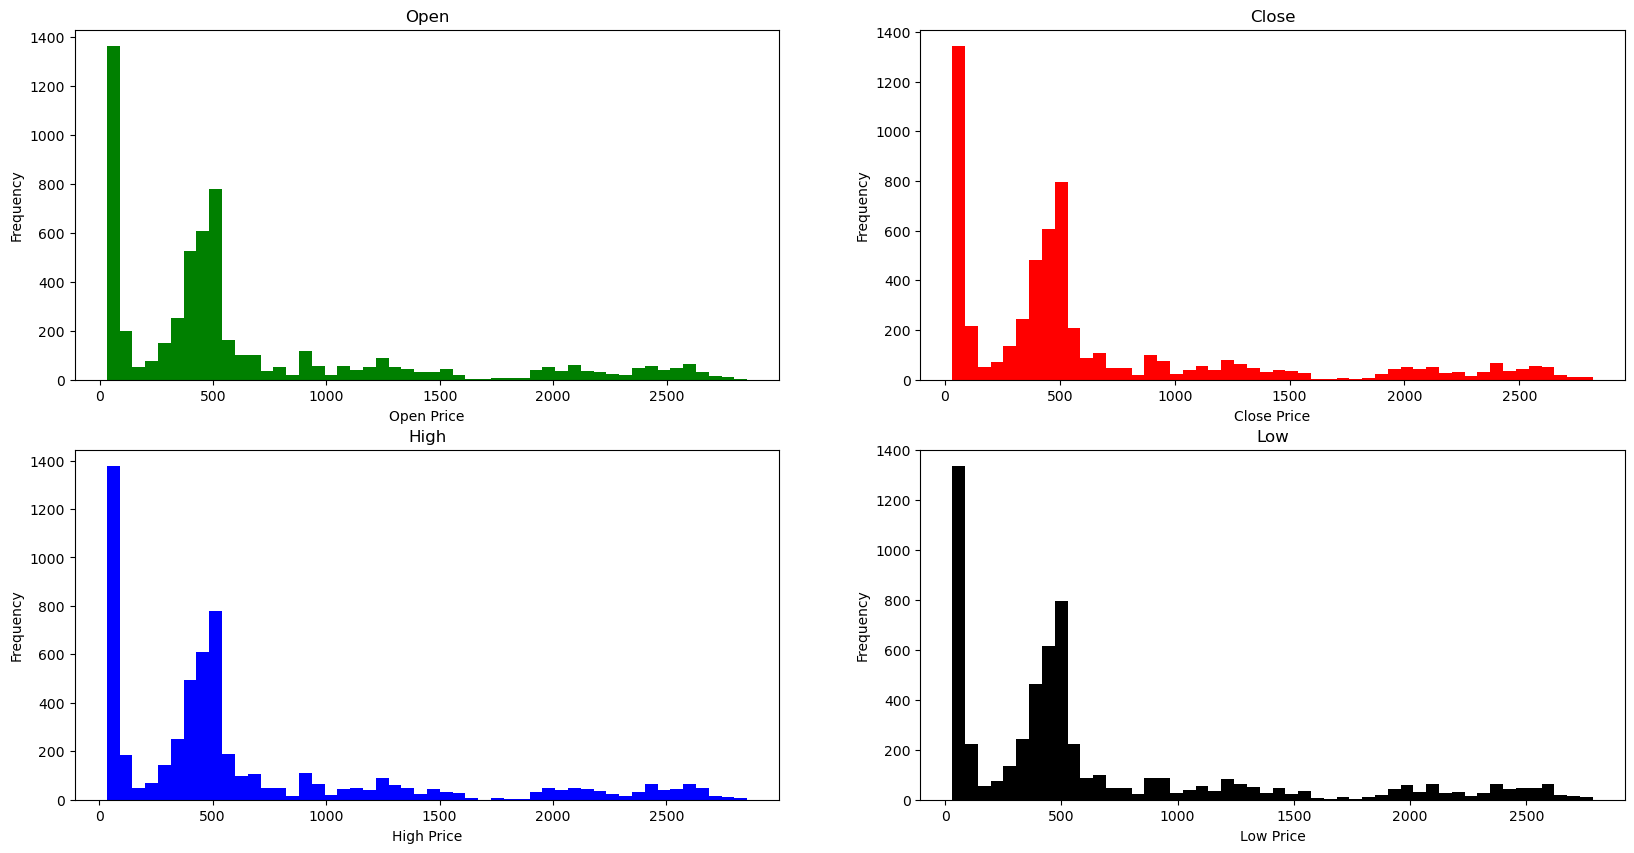

In [14]:
# Plotting Histograms for all the columns

plt.figure(figsize=(20,10))
#Plot 1
plt.subplot(2,2,1)
plt.hist(df['Open'],bins=50, color='green')
plt.xlabel("Open Price")
plt.ylabel("Frequency")
plt.title('Open')
#Plot 2
plt.subplot(2,2,2)
plt.hist(df['Close'],bins=50, color='red')
plt.xlabel("Close Price")
plt.ylabel("Frequency")
plt.title('Close')
#Plot 3
plt.subplot(2,2,3)
plt.hist(df['High'],bins=50, color='blue')
plt.xlabel("High Price")
plt.ylabel("Frequency")
plt.title('High')
#Plot 4
plt.subplot(2,2,4)
plt.hist(df['Low'],bins=50, color='black')
plt.xlabel("Low Price")
plt.ylabel("Frequency")
plt.title('Low')

Text(0.5, 1.0, 'Low')

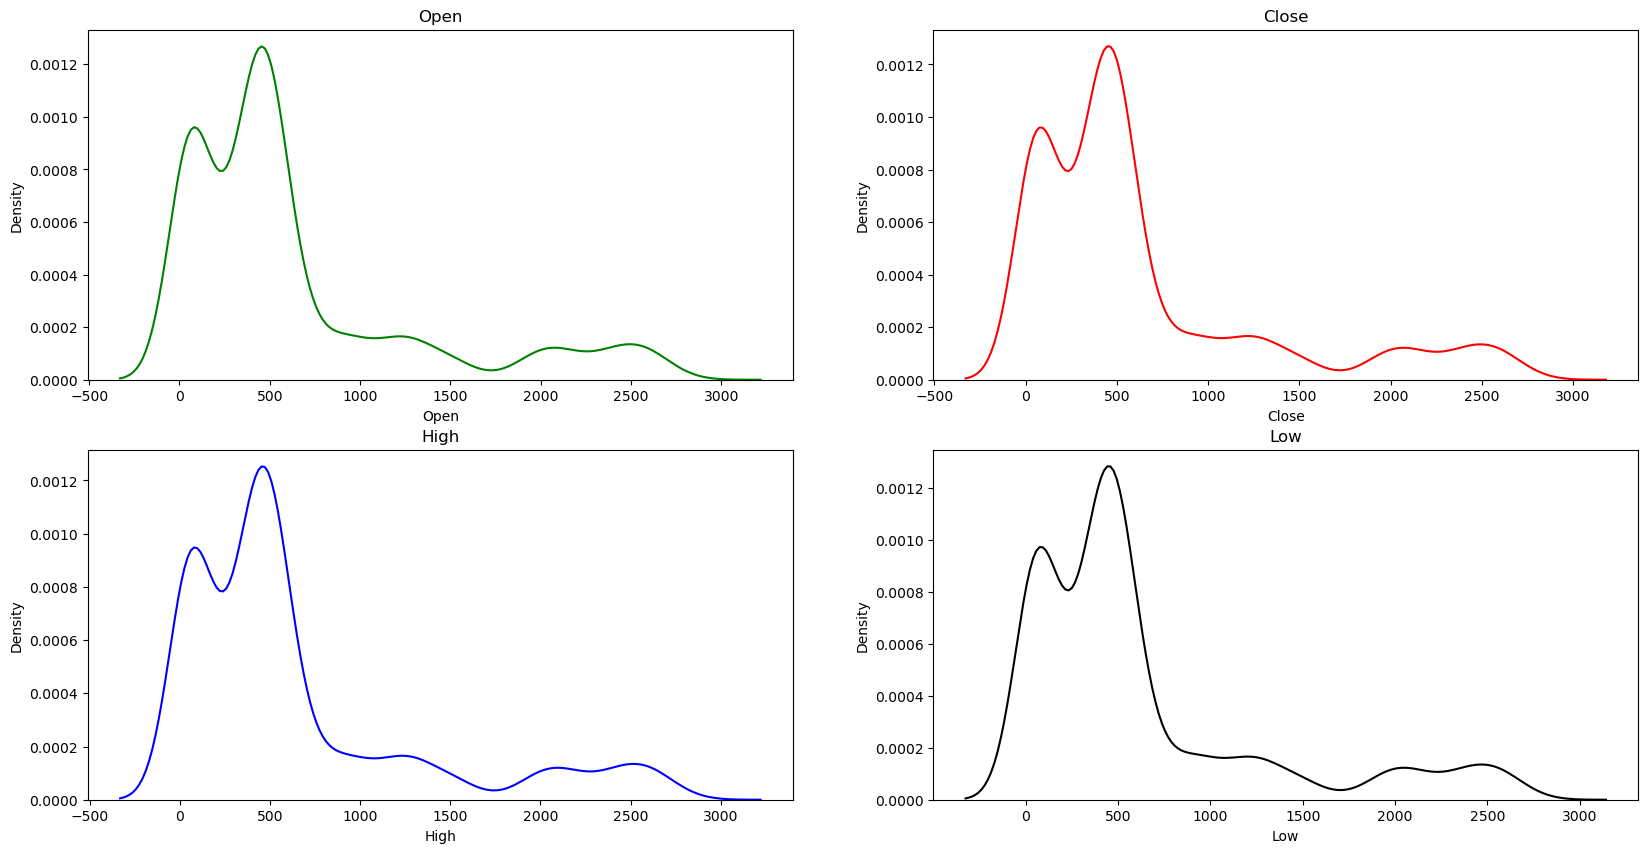

In [15]:
# KDE-Plots

plt.figure(figsize=(20,10))
#Plot 1
plt.subplot(2,2,1)
sns.kdeplot(df['Open'], color='green')
plt.title('Open')
#Plot 2
plt.subplot(2,2,2)
sns.kdeplot(df['Close'], color='red')
plt.title('Close')
#Plot 3
plt.subplot(2,2,3)
sns.kdeplot(df['High'], color='blue')
plt.title('High')
#Plot 4
plt.subplot(2,2,4)
sns.kdeplot(df['Low'], color='black')
plt.title('Low')

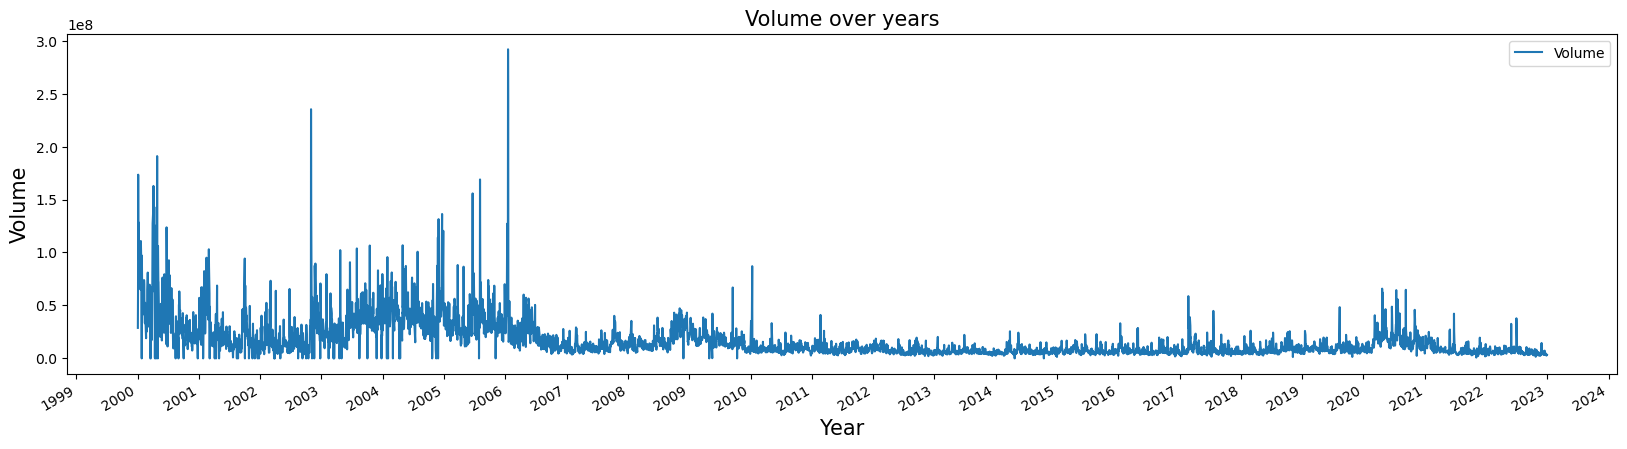

In [16]:
# Visualizing the column 'Volume'

ax = df[['Volume']].plot(stacked=True)
fig = plt.gcf()
fig.set_size_inches(20, 5) 
ax.set_title('Volume over years', fontsize=15)
ax.set_xlabel('Year', fontsize=15)
ax.set_ylabel('Volume', fontsize=15)
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.show()

##### Insights:

1. There were large volumes of shares traded between 2000-2008.
2. The thin phase lies between 2012-2020. In this phase, there have not been big volumes of shares traded.
3. However, there is a rise after 2020 in the volume of shares being traded which eventually ended in a dip.

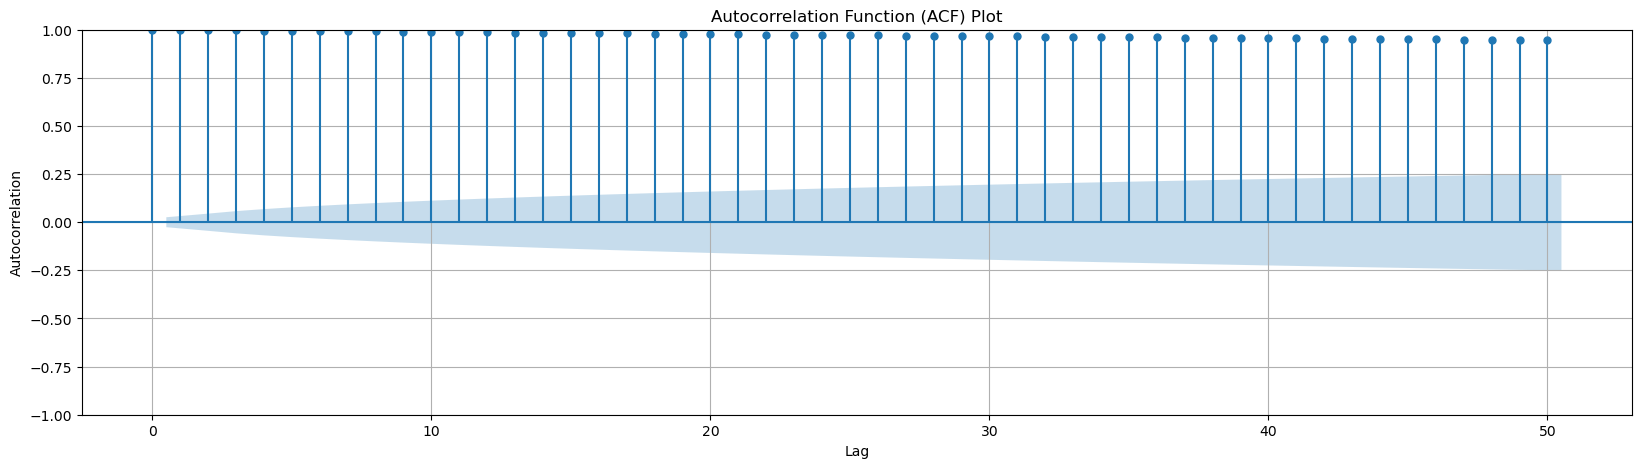

In [17]:
# Visualize Plot ACF

plt.rcParams.update({'figure.figsize':(20,5)})
plot_acf(df['Close'], lags=50)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Function (ACF) Plot')
plt.grid(True)
plt.show()

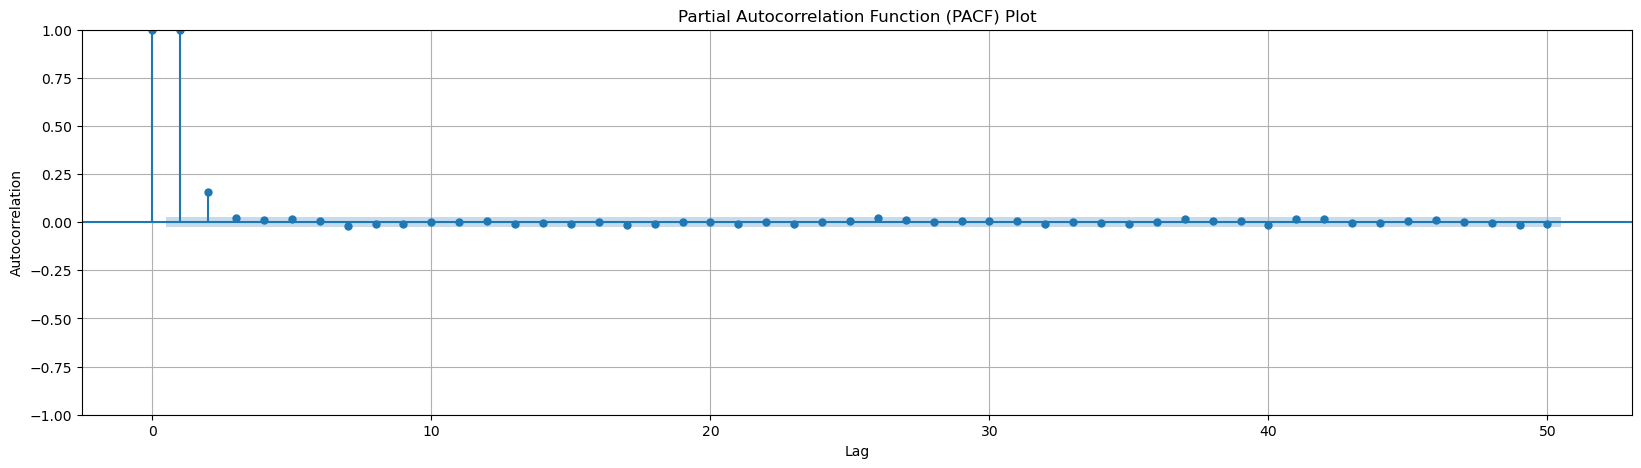

In [18]:
# Visualize Plot PACF

plt.rcParams.update({'figure.figsize':(20,5)})
plot_pacf(df['Close'], lags=50)  # Adjust lags as needed
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Partial Autocorrelation Function (PACF) Plot')
plt.grid(True)
plt.show()

We will investigate the closing price trend further.

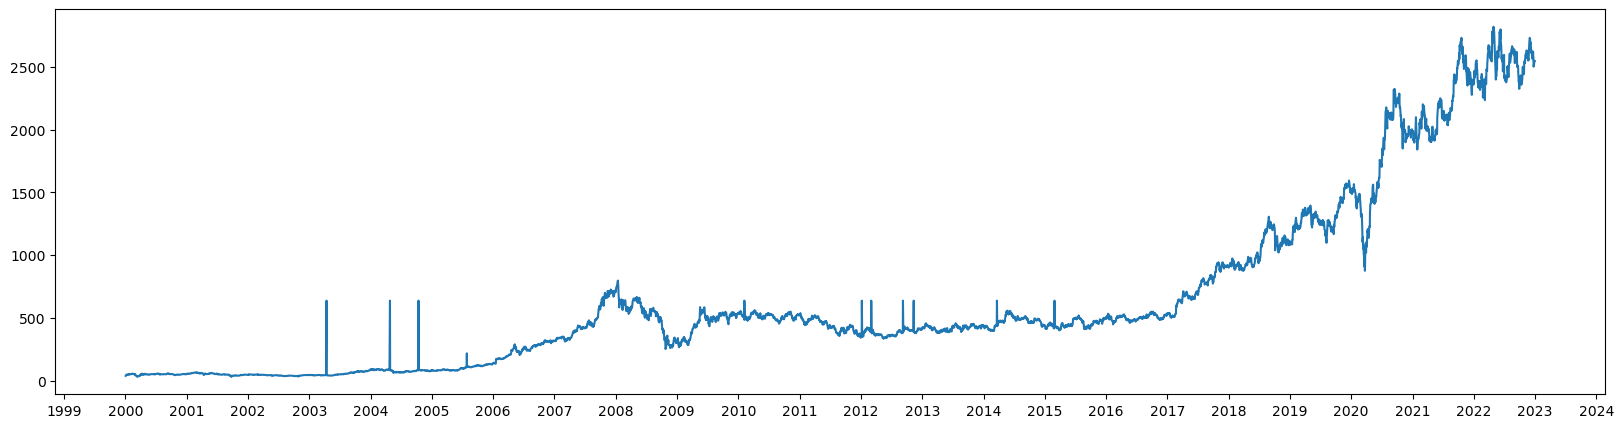

In [19]:
# Visualizing the closing price trend

plt.rcParams.update({'figure.figsize':(20,5)})
plt.plot(df['Close'])
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

## Model Fitting - SARIMAX

#### Hypothesis Test: To evaluate Stationarity

    Null Hypothesis: Time series is non-stationary.
    Alternative Hypothesis: Time series is Stationary.

So, if the p-value of the test is less than the significance level of 0.05, then we can reject the null hypothesis and infer that the time series is indeed stationary.

In [20]:
# Resample daily data to monthly (taking the mean of daily values)
monthly_df = df.resample('M').mean()
monthly_df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-31,47.294993,48.735788,46.452841,47.825483,36.453376,8.298989e+07
2000-02-29,53.416254,54.192832,52.146026,52.924814,40.340171,4.706210e+07
2000-03-31,39.327014,40.576259,37.581299,39.032361,29.751113,5.099867e+07
2000-04-30,50.866607,52.449455,49.332884,51.030229,39.618739,9.408359e+07
2000-05-31,50.258752,51.253708,49.302476,50.203924,39.094372,4.366316e+07
...,...,...,...,...,...,...
2022-08-31,2606.609998,2632.967493,2583.697522,2610.795007,2606.508289,5.427309e+06
2022-09-30,2509.972723,2534.663630,2488.275013,2505.081832,2505.081832,5.402364e+06
2022-10-31,2433.555253,2461.002634,2414.344739,2437.052644,2437.052644,4.973588e+06


In [21]:
# Specify the period for seasonal decomposition
period = 12 

model=seasonal_decompose(monthly_df['Close'],model='additive', period=period)
model

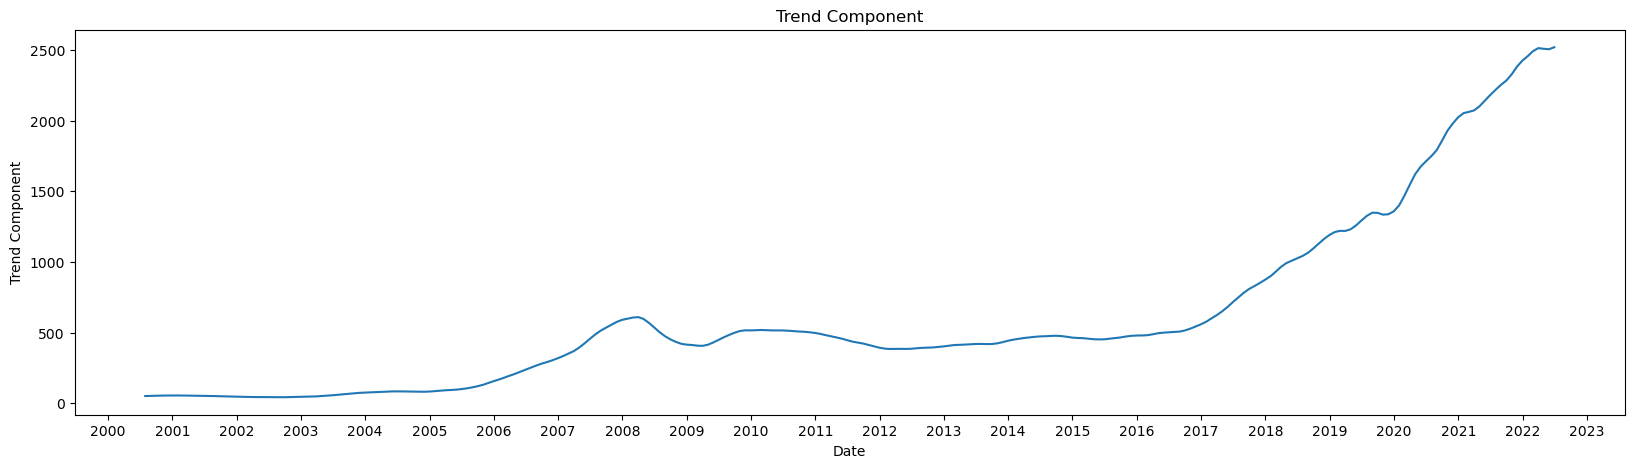

In [22]:
# Visualizing trend plot

plt.figure(figsize=(20, 5))
plt.plot(model.trend)
plt.title('Trend Component')
plt.xlabel('Date')
plt.ylabel('Trend Component')
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

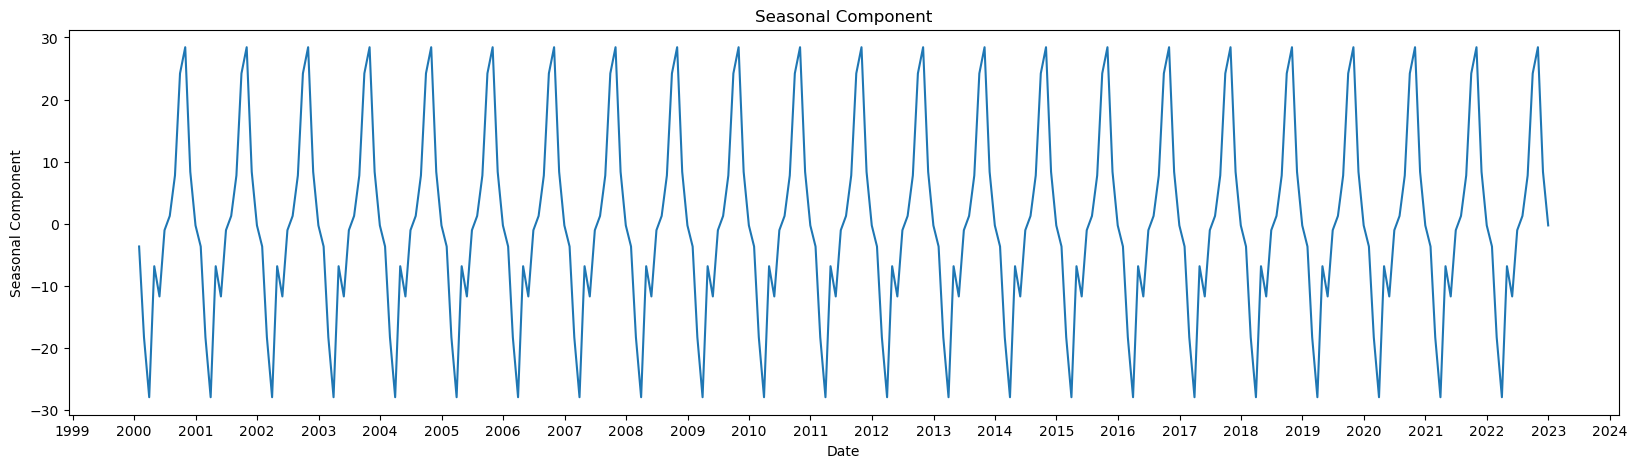

In [23]:
# Visualizing seasonal plot

plt.figure(figsize=(20, 5))
plt.plot(model.seasonal)
plt.title('Seasonal Component')
plt.xlabel('Date')
plt.ylabel('Seasonal Component')
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

We can see that there is yearly seasonality in the data.

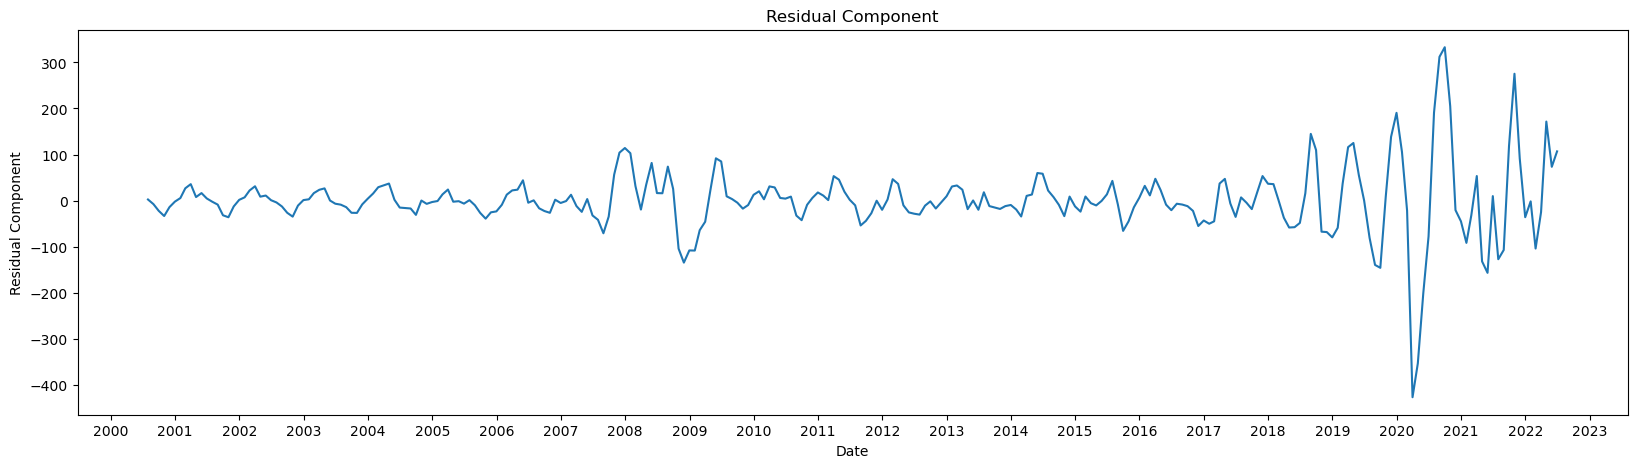

In [24]:
# Visualizing residual plot

plt.figure(figsize=(20, 5))
plt.plot(model.resid)
plt.title('Residual Component')
plt.xlabel('Date')
plt.ylabel('Residual Component')
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

#### Analysis from the Visualizations

1. Trends: There is an overall positive trend for the closing prices of the stock, since the closing price value at the end is higher than the closing price value at the beginning.
2. Seasonality: There is yearly seasonality in the closing prices.
3. Residuals: There is some residual in the dataset.

In [25]:
# Copy dataset containing only 'Date' and 'Close' columns
df_sarimax = monthly_df[['Close']]
df_sarimax

,Close
Date,
2000-01-31,47.825483
2000-02-29,52.924814
2000-03-31,39.032361
2000-04-30,51.030229
2000-05-31,50.203924
...,...
2022-08-31,2610.795007
2022-09-30,2505.081832
2022-10-31,2437.052644


In [26]:
# Hypothesis Test

result = adfuller(df_sarimax)
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
print('Critical Values:', result[4])
if result[1] > 0.05:
    print("\nAccept Null Hypothesis: Data is non-stationary")
else:
    print("\nReject Null Hypothesis: Data is stationary")

ADF Statistic: 1.510838288066995
p-value: 0.9975638235599604
Critical Values: {'1%': -3.4556556713934934, '5%': -2.872678352489859, '10%': -2.57270548832225}

Accept Null Hypothesis: Data is non-stationary


In our case, the p-value is > 0.05. Hence, we will need to find the order of differencing.

#### Getting Order of Differencing

As we have identified that our data is not stationary, we have to make it stationary to apply the time series model. We will difference the series and perform ACF and PACF test to determine the values of p and q. 

<Axes: xlabel='Date'>

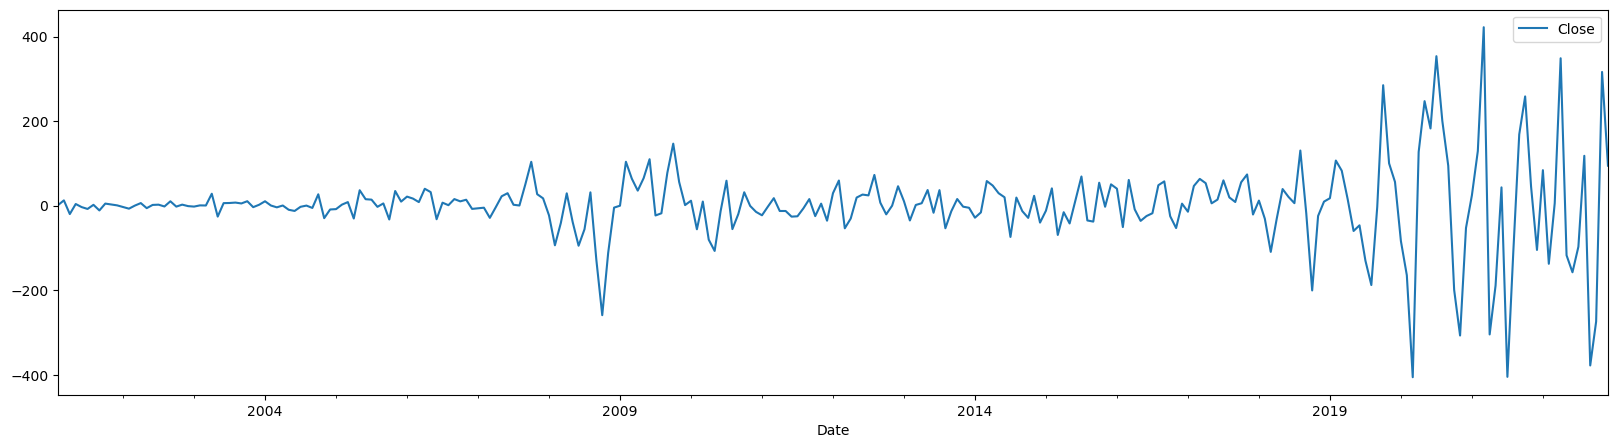

In [27]:
# 1st time differencing 'Close' - remove seasonality
df_sarimax_data = df_sarimax.copy()
df_sarimax_data['Close'] = df_sarimax_data['Close'] - df_sarimax_data['Close'].shift(1)
df_sarimax_data['Close'] = df_sarimax_data['Close'] - df_sarimax_data['Close'].shift(12)
df_sarimax_data.dropna().plot()

From this graph, we can see that the seasonality and the trend has been removed.

In [28]:
# Getting the ADF Statistic and p-value

result = adfuller(df_sarimax_data['Close'].dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:', result[4])

ADF Statistic: -4.994624
p-value: 0.000023
Critical Values: {'1%': -3.457215237265747, '5%': -2.873361841566324, '10%': -2.5730700760129555}


Since the ADF statistic is less than critical values and the p-value is below 0.05, we can reject the null hypothesis of a unit root and conclude that the data is stationary.

As the data became stationary after differencing it once, the value for d is 1.

#### Getting the order of AutoRegressive Model (q)

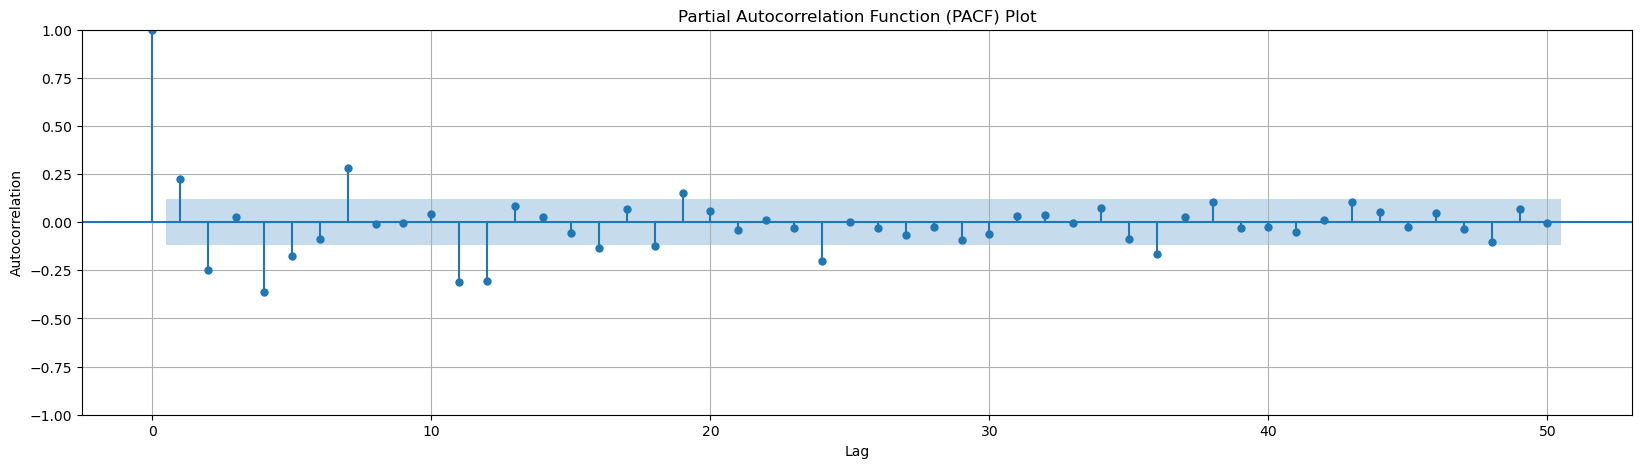

In [29]:
# Visualize Plot PACF
plot_pacf(df_sarimax_data['Close'].dropna(), lags=50)  # Adjust lags as needed
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Partial Autocorrelation Function (PACF) Plot')
plt.grid(True)
plt.show()

From the PACF Plot after 1st differencing, we can see that the PACF lag (q) 7 is significant as it is just above the significance line.

Therefore, we will consider q = 7

#### Getting order of Moving Average

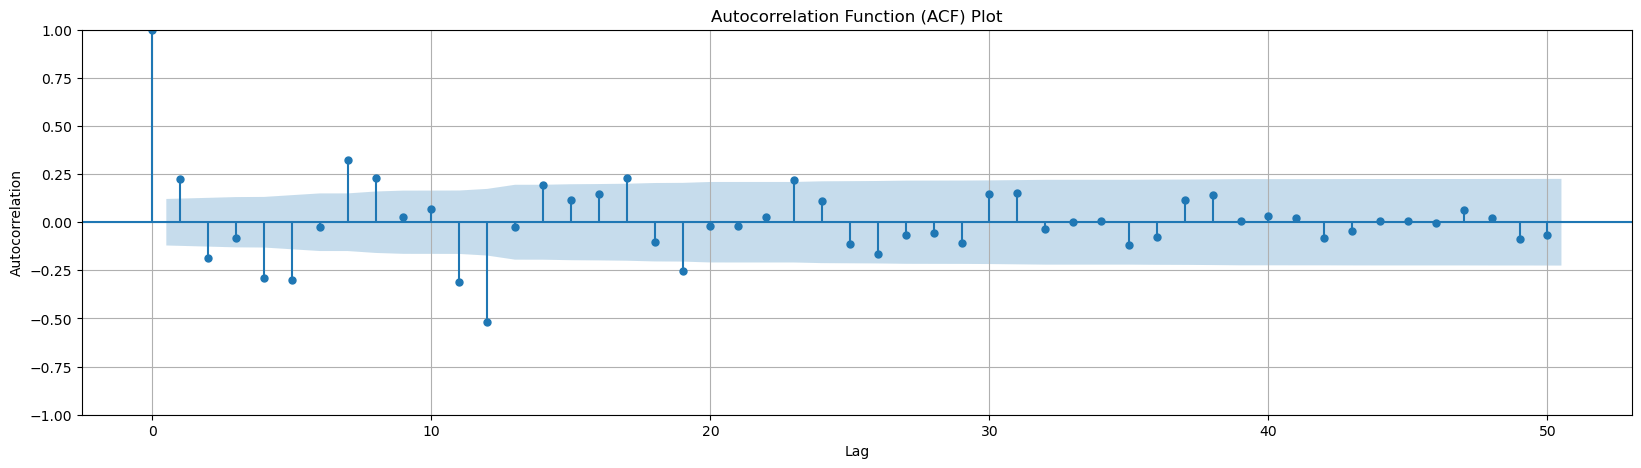

In [30]:
# Visualize ACF plots
plot_acf(df_sarimax_data['Close'].dropna(), lags=50)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Function (ACF) Plot')
plt.grid(True)
plt.show()

From the ACF Plot after 1st differencing, we can see that the ACF lag (p) 7 is significant as it is well above the significance line.

So, we will consider p = 7.

#### Fitting the SARIMAX Model

In [31]:
# Split dataset into training and testing (80% train, 20% test)

train_size = int(len(df_sarimax) * 0.8)
train, test = df_sarimax['Close'].iloc[:train_size], df_sarimax['Close'].iloc[train_size:]

In [32]:
# Instantiate the SARIMA model
model = SARIMAX(train,
    order=(7,1,7), # order=(p,d,q)
    seasonal_order=(7,1,7,12)
)
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              Close   No. Observations:                  220
Model:             SARIMAX(7, 1, 7)x(7, 1, 7, 12)   Log Likelihood                -984.617
Date:                            Thu, 01 Aug 2024   AIC                           2027.235
Time:                                    01:13:52   BIC                           2123.883
Sample:                                01-31-2000   HQIC                          2066.319
                                     - 04-30-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0456      0.434     -0.105      0.916      -0.896       0.805
ar.L2          0.0811      0.319      0.255      0.799      -0.543       0.705
ar.L3          0.3927      0.374      1.049      0.294      -0.341       1.126
ar.L4          0.1617      0.390      0.414      0.679      -0.603       0.927
ar.L5          0.2533      0.348      0.727      0.467      -0.429       0.936
ar.L6         -0.7750      0.241     -3.220      0.001      -1.247      -0.303
ar.L7         -0.4146      0.422     -0.983      0.326      -1.242       0.412
ma.L1          0.3190      1.639      0.195      0.846      -2.894       3.532
ma.L2         -0.2090      1.460     -0.143      0.886      -3.071       2.653
ma.L3         -0.3561      0.959     -0.371      0.710      -2.235       1.523
ma.L4         -0.1780      0.824     -0.216      0.829      -1.793       1.437
ma.L5         -0.2939      1.515     -0.194      0.846      -3.264       2.676
ma.L6          0.7485      1.875      0.399      0.690      -2.927       4.424
ma.L7          0.6481      1.050      0.617      0.537      -1.410       2.706
ar.S.L12       0.0462     13.677      0.003      0.997     -26.759      26.852
ar.S.L24       1.7901     17.610      0.102      0.919     -32.724      36.305
ar.S.L36      -0.5401     26.803     -0.020      0.984     -53.072      51.992
ar.S.L48      -1.3584     34.143     -0.040      0.968     -68.277      65.561
ar.S.L60       0.3147     14.416      0.022      0.983     -27.939      28.569
ar.S.L72       0.3569     10.371      0.034      0.973     -19.970      20.684
ar.S.L84      -0.0147      1.535     -0.010      0.992      -3.023       2.993
ma.S.L12      -0.9972     20.889     -0.048      0.962     -41.938      39.944
ma.S.L24      -1.9521     31.330     -0.062      0.950     -63.357      59.453
ma.S.L36       2.4824     43.087      0.058      0.954     -81.966      86.931
ma.S.L48       1.1122     42.612      0.026      0.979     -82.406      84.631
ma.S.L60      -2.0150     52.241     -0.039      0.969    -104.406     100.376
ma.S.L72      -0.0938     21.703     -0.004      0.997     -42.631      42.444
ma.S.L84       0.5187     16.721      0.031      0.975     -32.253      33.291
sigma2       701.6931   1.15e+04      0.061      0.951   -2.18e+04    2.32e+04
===================================================================================
Ljung-Box (L1) (Q):                   1.64   Jarque-Bera (JB):                67.97
Prob(Q):                              0.20   Prob(JB):                         0.00
Heteroskedasticity (H):               3.84   Skew:                            -0.31
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

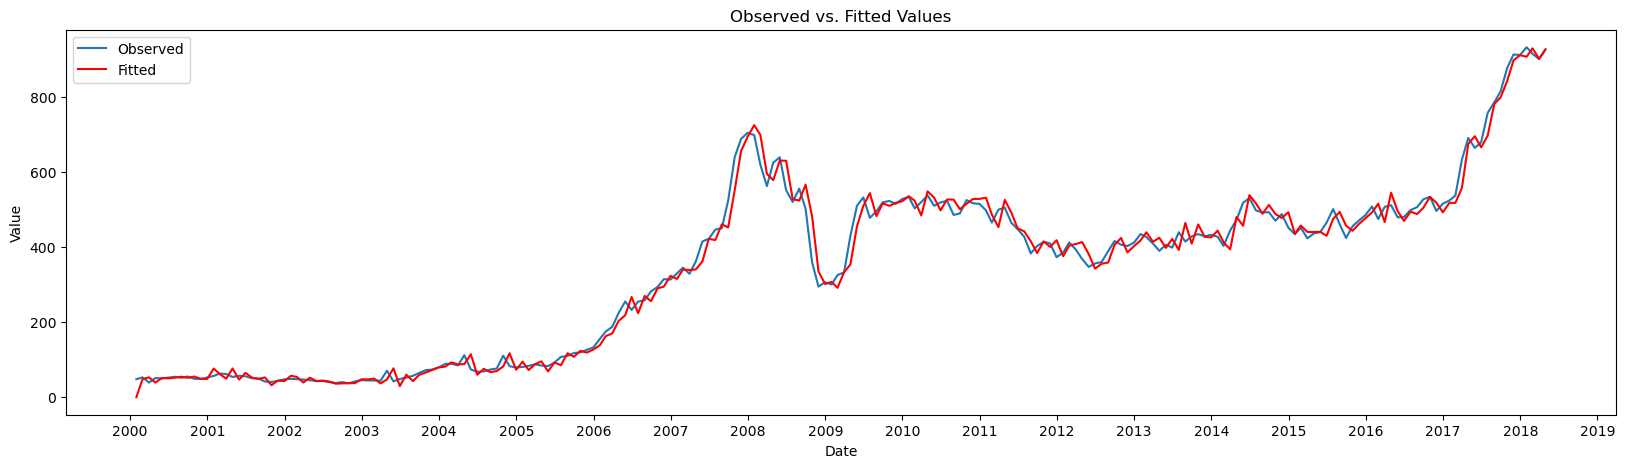

In [33]:
# Plotting the actual vs. fitted values
plt.figure(figsize=(20, 5))

plt.plot(train, label='Observed')
plt.plot(model_fit.fittedvalues, label='Fitted', color='red')
plt.title('Observed vs. Fitted Values')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.show()

In [34]:
# Evaluate Model Parameters

predictions = model_fit.forecast(steps=int(len(test)))
print(f'Root Mean Squared Error: {math.sqrt(mean_squared_error(test,predictions))}')
print(f'Mean Squared Error: {mean_squared_error(test,predictions)}')
print(f'Mean Absolute Error: {mean_absolute_error(test,predictions)}')
print(f'R2 Score: {r2_score(test, predictions)}')

Root Mean Squared Error: 991.0864764055071
Mean Squared Error: 982252.4037138838
Mean Absolute Error: 847.7784606386732
R2 Score: -2.1132175407002736


In [35]:
# Make Predictions
train_predict = model_fit.predict(start=train.index[0], end=train.index[-1])
test_predict = model_fit.predict(start=test.index[0], end=test.index[-1])

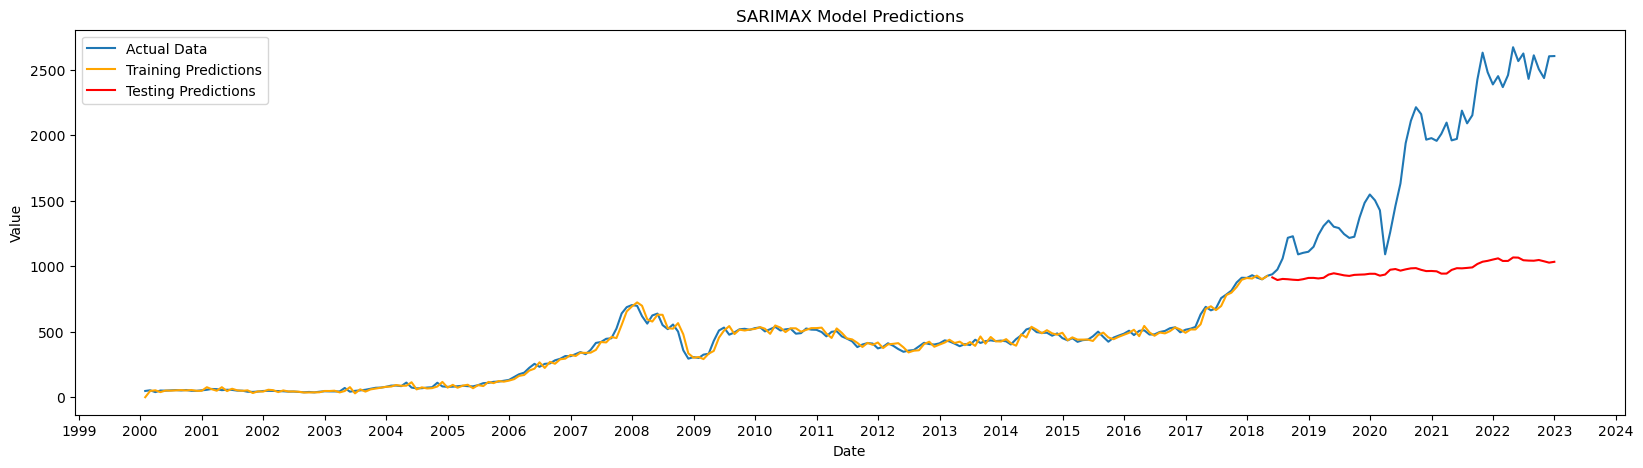

In [36]:
# Plot training and test data along with predictions
plt.figure(figsize=(20, 5))

# Plot actual data
plt.plot(monthly_df.index, monthly_df['Close'], label='Actual Data')

# Plot training predictions
plt.plot(train_predict.index, train_predict, label='Training Predictions', color='orange')

# Plot testing predictions
plt.plot(test_predict.index, test_predict, label='Testing Predictions', color='red')

plt.xlabel('Date')
plt.ylabel('Value')
plt.title('SARIMAX Model Predictions')
plt.legend()
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.show()

#### Making Forecasts

In [37]:
# Forecast period from the end of available data
start = len(monthly_df)
 
# and it will end 36 months later
end = (len(monthly_df) - 1) + 3*12
 
# Build a forecast for three years ahead (2023-2026)
forecasts = model_fit.predict(start, end)

# Convert predictions to DataFrame for easier handling
forecasts_df = pd.Series(forecasts, index=forecasts.index)

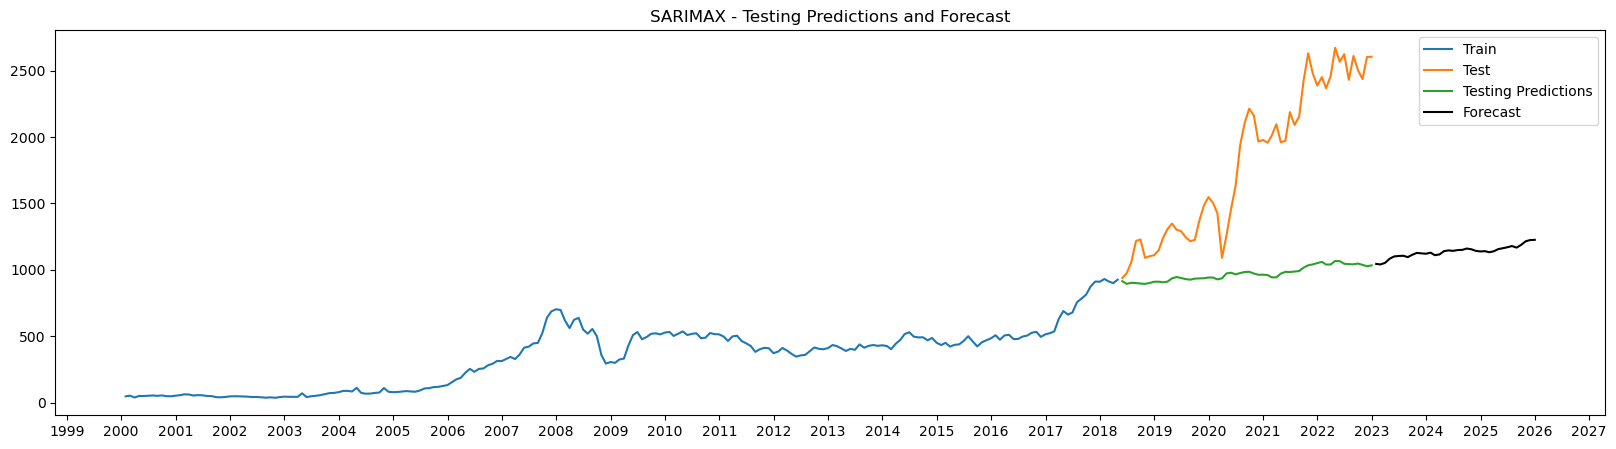

In [38]:
# Plotting forecast
plt.figure(figsize=(20, 5))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(predictions.index, predictions, label="Testing Predictions")
plt.plot(forecasts_df.index, forecasts_df, label='Forecast', color='black')
plt.title('SARIMAX - Testing Predictions and Forecast')
plt.legend()
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.show()

#### Analysis

1. Model Fit: The SARIMAX model has statistically significant coefficients for both moving average terms. The model captures autocorrelation well but has residuals that deviate from normality and exhibit heteroskedasticity.
2. Model Diagnostics: Residuals show significant deviations from normality and non-constant variance. These issues suggest the need for further model refinement or additional diagnostic checks.

#### Residual Analysis

In [39]:
# Get residuals

residuals = model_fit.resid
print("Residuals Mean: ")
residuals.mean()

Residuals Mean: 


1.346422779682649

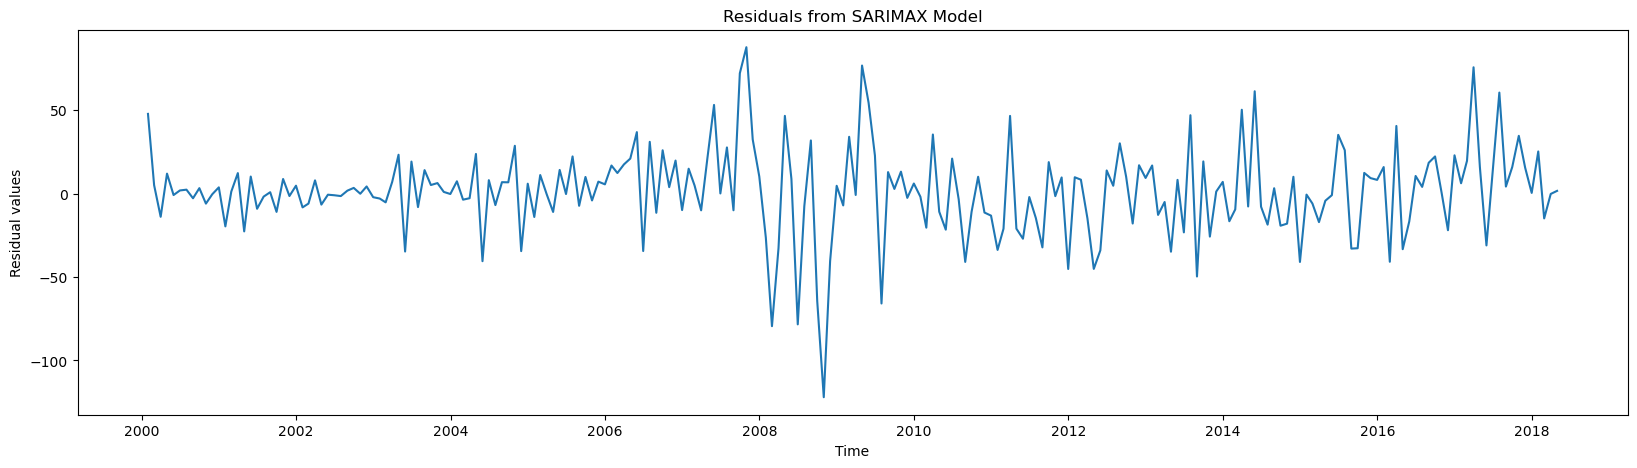

In [40]:
# Plot Residuals

plt.figure(figsize=(20, 5))
plt.plot(residuals)
plt.title('Residuals from SARIMAX Model')
plt.xlabel('Time')
plt.ylabel('Residual values')
plt.show()

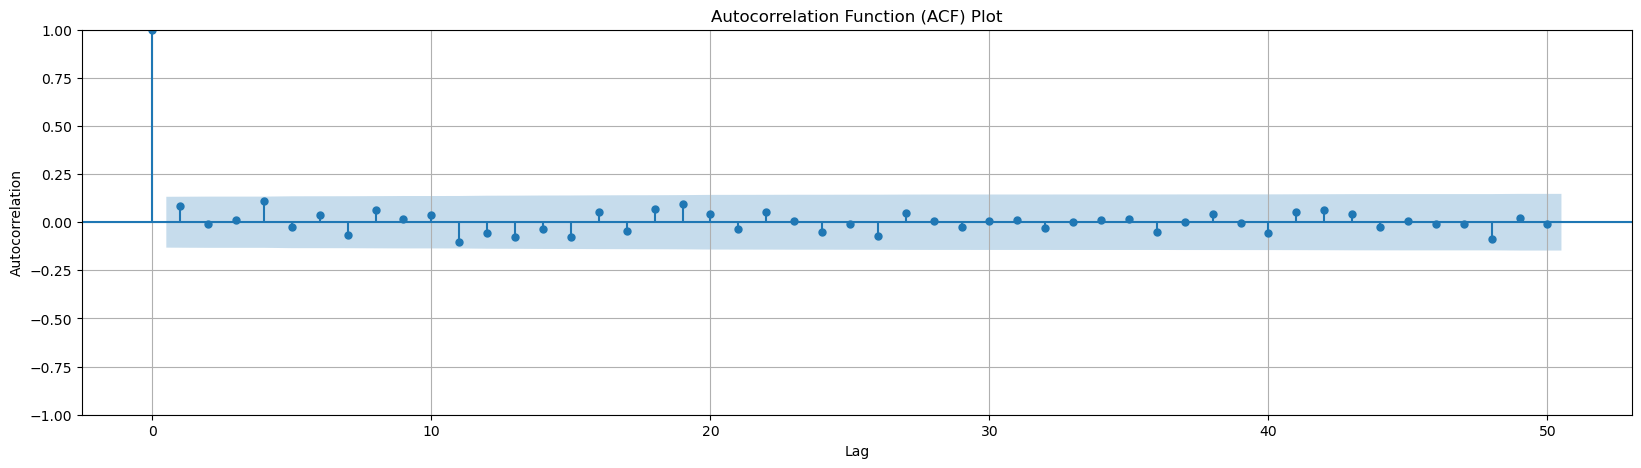

In [41]:
# Visualize ACF plots
plot_acf(residuals, lags=50)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Function (ACF) Plot')
plt.grid(True)
plt.show()

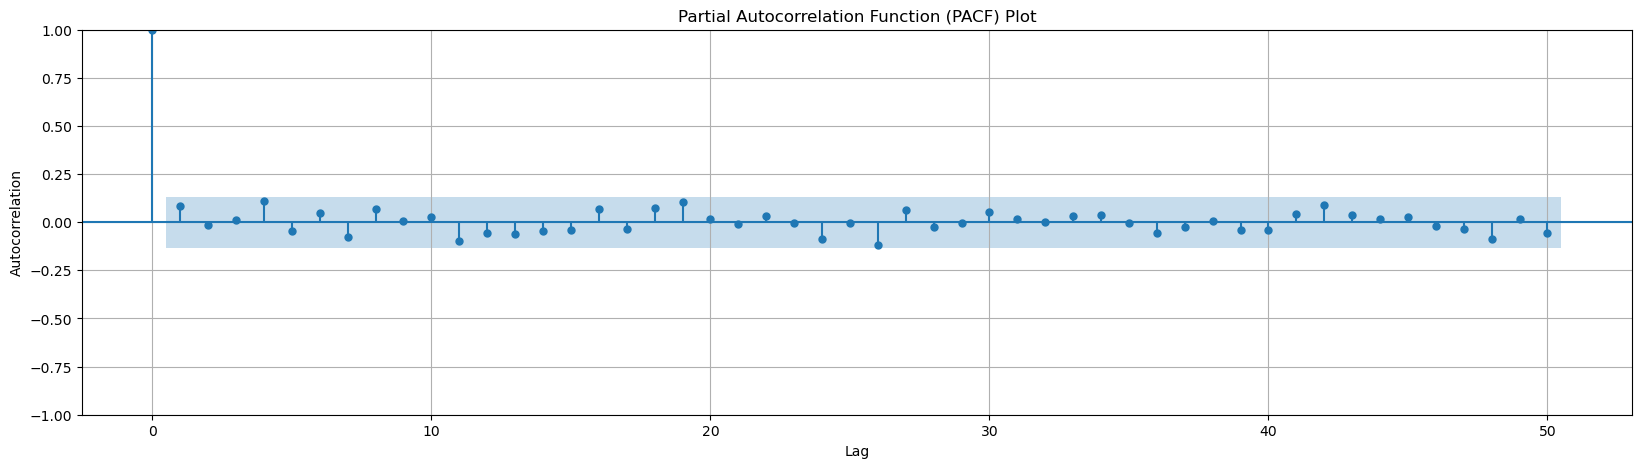

In [42]:
# Visualize Plot PACF
plot_pacf(residuals, lags=50)  # Adjust lags as needed
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Partial Autocorrelation Function (PACF) Plot')
plt.grid(True)
plt.show()

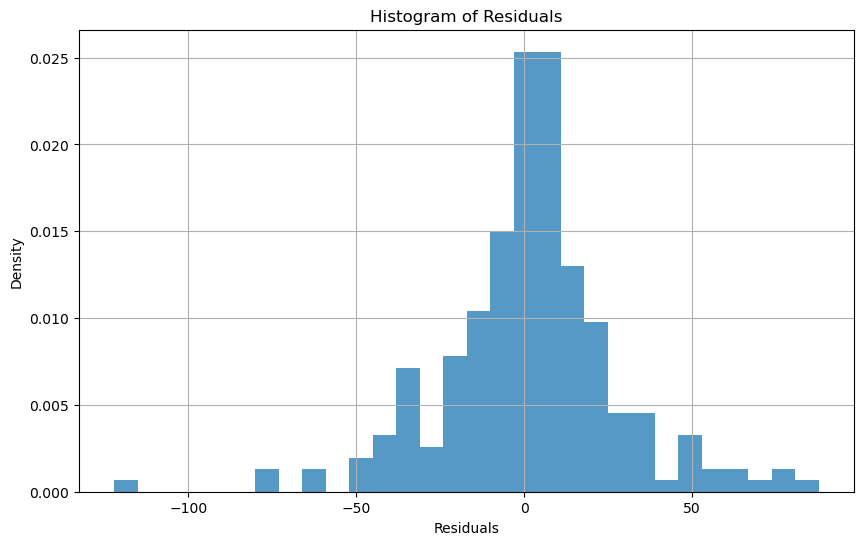

In [43]:
# Visualizng Histogram of residuals

plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30, density=True, alpha=0.75)
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.grid(True)
plt.show()

#### Hyperparameter Tuning

In [44]:
# Performing grid search for SARIMAX

optimized_model = pm.auto_arima(
    train.dropna(),
    start_p=1,
    start_q=1,
    test='adf', # adf test to find optimal 'd'
    max_p=7,
    max_q=7,
    m=12,
    start_P=0,
    seasonal=True,
    d=1,
    D=1,
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True
)

optimized_model.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=0.48 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=2140.713, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=2065.124, Time=0.13 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.45 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=2116.519, Time=0.05 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=2039.422, Time=0.31 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=1.01 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.56 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=2055.346, Time=0.26 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=2034.961, Time=0.49 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=2063.129, Time=0.24 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=1.60 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=0.80 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=2028.368, Time=0.62 sec
 ARIMA(3,1,0)(1,1,0)[12]             : AIC=2058.5

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  220
Model:             SARIMAX(3, 1, 0)x(2, 1, 0, 12)   Log Likelihood               -1008.184
Date:                            Thu, 01 Aug 2024   AIC                           2028.368
Time:                                    01:14:27   BIC                           2048.364
Sample:                                01-31-2000   HQIC                          2036.454
                                     - 04-30-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3756      0.051      7.418      0.000       0.276       0.475
ar.L2         -0.2465      0.065     -3.794      0.000      -0.374      -0.119
ar.L3          0.2016      0.056      3.578      0.000       0.091       0.312
ar.S.L12      -0.6776      0.053    -12.860      0.000      -0.781      -0.574
ar.S.L24      -0.3797      0.066     -5.781      0.000      -0.508      -0.251
sigma2       960.7634     84.127     11.420      0.000     795.878    1125.649
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                32.77
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               3.30   Skew:                            -0.60
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.53
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [45]:
sarima_order = optimized_model.order
seasonal_order = optimized_model.seasonal_order

print(f'Best SARIMAX order: {sarima_order}')
print(f'Best SARIMAX seasonal order: {seasonal_order}')

Best SARIMAX order: (3, 1, 0)
Best SARIMAX seasonal order: (2, 1, 0, 12)


#### Building Model using Optimized SARIMAX Model

In [46]:
sarimax_model = SARIMAX(
    train,
    order=(3, 1, 0), # order=(p,d,q)
    seasonal_order=(2, 1, 0, 12)
) 
sarimax_model = sarimax_model.fit()
sarimax_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              Close   No. Observations:                  220
Model:             SARIMAX(3, 1, 0)x(2, 1, 0, 12)   Log Likelihood               -1008.184
Date:                            Thu, 01 Aug 2024   AIC                           2028.368
Time:                                    01:14:27   BIC                           2048.364
Sample:                                01-31-2000   HQIC                          2036.454
                                     - 04-30-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3756      0.051      7.418      0.000       0.276       0.475
ar.L2         -0.2465      0.065     -3.794      0.000      -0.374      -0.119
ar.L3          0.2016      0.056      3.578      0.000       0.091       0.312
ar.S.L12      -0.6776      0.053    -12.860      0.000      -0.781      -0.574
ar.S.L24      -0.3797      0.066     -5.781      0.000      -0.508      -0.251
sigma2       960.7634     84.127     11.420      0.000     795.878    1125.649
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                32.77
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               3.30   Skew:                            -0.60
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.53
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

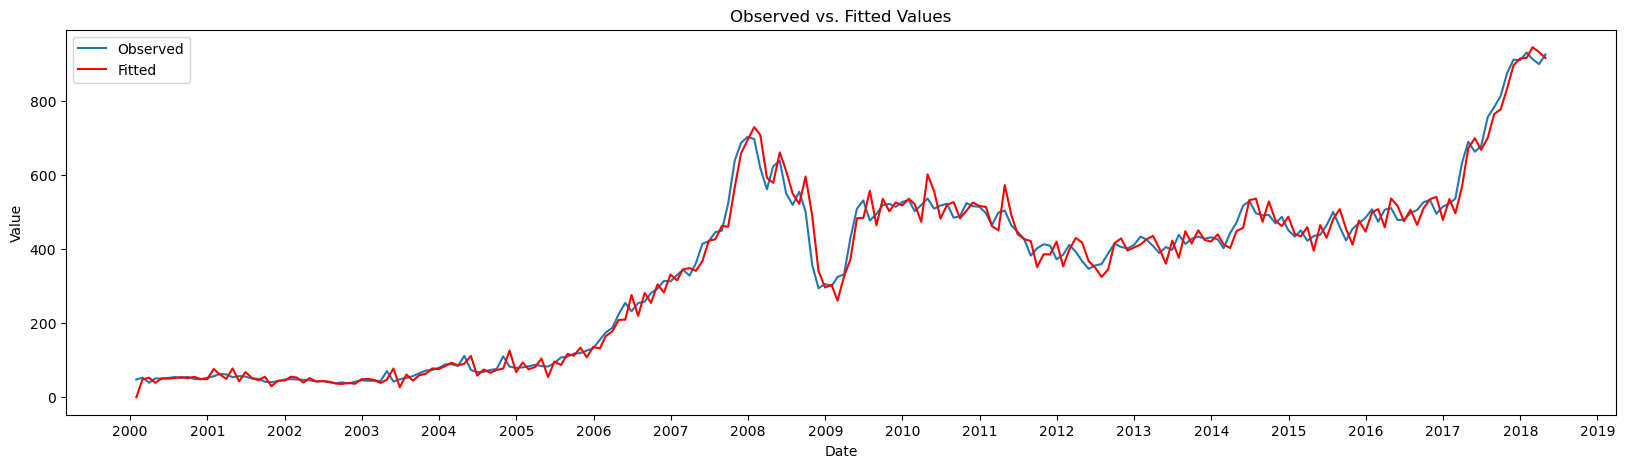

In [47]:
# Plotting the actual vs. fitted values
plt.figure(figsize=(20, 5))

plt.plot(train, label='Observed')
plt.plot(sarimax_model.fittedvalues, label='Fitted', color='red')
plt.title('Observed vs. Fitted Values')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.show()

In [48]:
# Evaluate Model Parameters

sarimax_predictions = sarimax_model.forecast(steps=int(len(test)))
print(f'Root Mean Squared Error: {math.sqrt(mean_squared_error(test,sarimax_predictions))}')
print(f'Mean Squared Error: {mean_squared_error(test,sarimax_predictions)}')
print(f'Mean Absolute Error: {mean_absolute_error(test,sarimax_predictions)}')
print(f'R2 Score: {r2_score(test, sarimax_predictions)}')

Root Mean Squared Error: 587.8279456230046
Mean Squared Error: 345541.69365536206
Mean Absolute Error: 494.05806395308707
R2 Score: -0.09518333339146845


#### Residual Analysis

In [49]:
# Get residuals

sarimax_residuals = sarimax_model.resid
print("Residuals Mean: ")
sarimax_residuals.mean()

Residuals Mean: 


1.2552462183838802

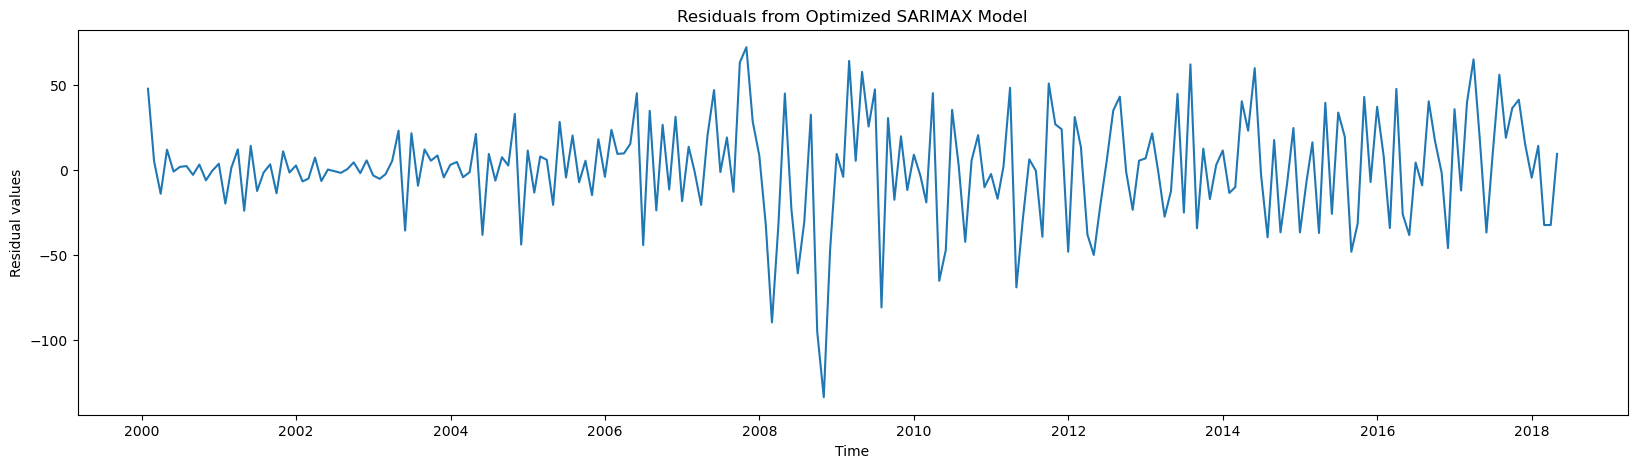

In [50]:
# Plot Residuals

plt.figure(figsize=(20, 5))
plt.plot(sarimax_residuals)
plt.title('Residuals from Optimized SARIMAX Model')
plt.xlabel('Time')
plt.ylabel('Residual values')
plt.show()

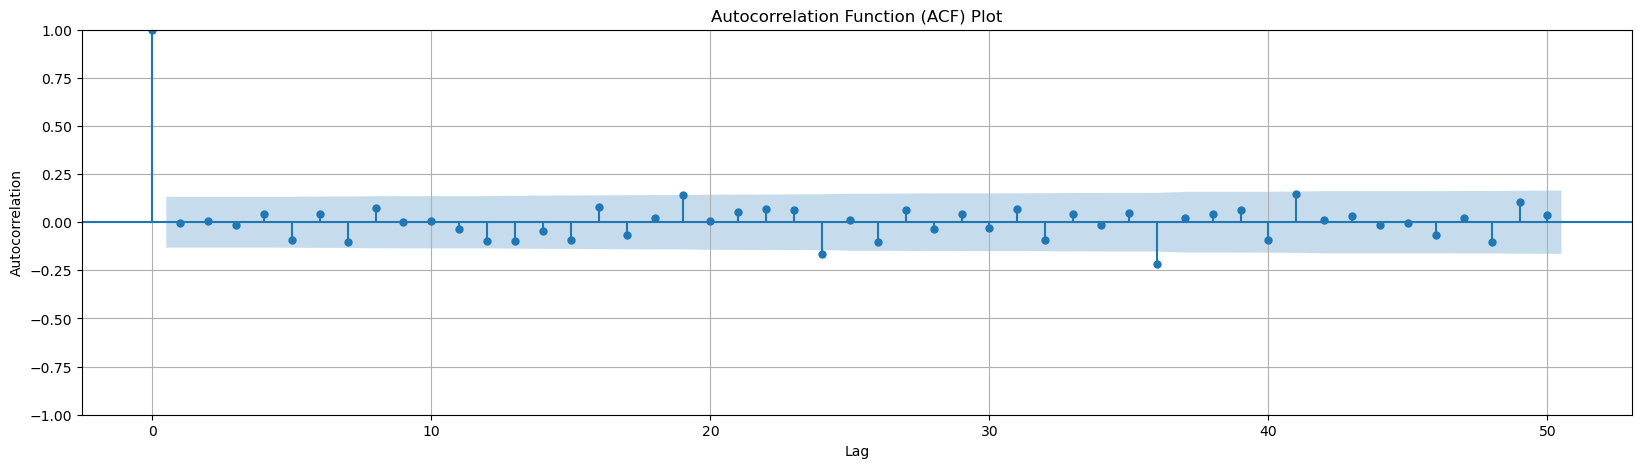

In [51]:
# Visualize ACF plots
plot_acf(sarimax_residuals, lags=50)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Function (ACF) Plot')
plt.grid(True)
plt.show()

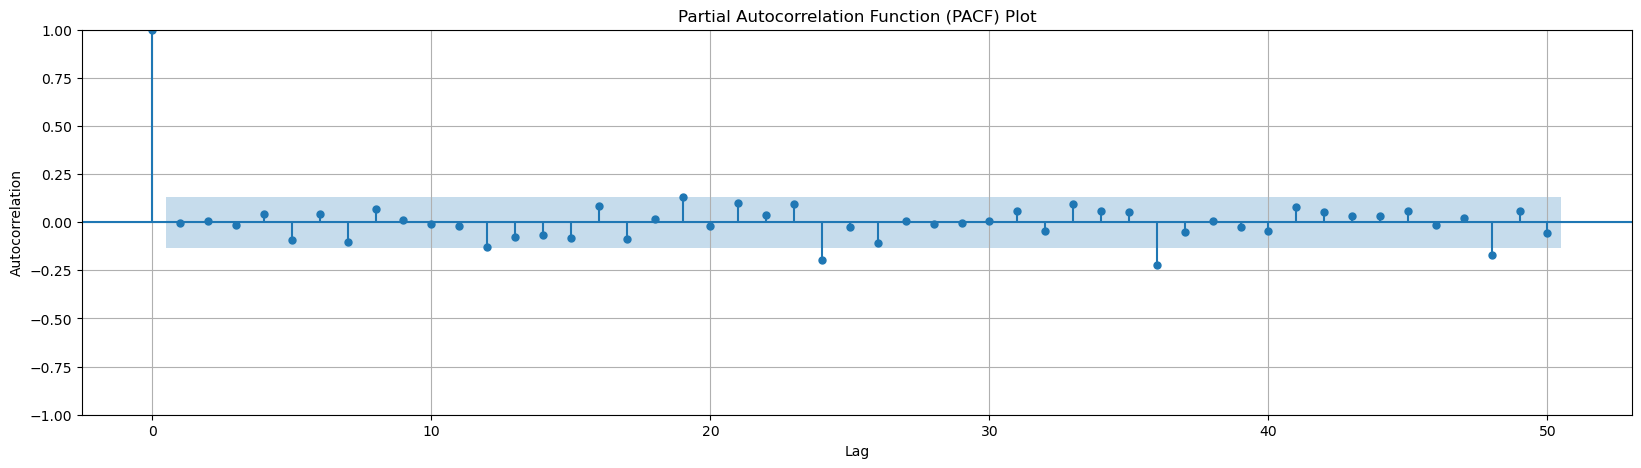

In [52]:
# Visualize Plot PACF
plot_pacf(sarimax_residuals, lags=50)  # Adjust lags as needed
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Partial Autocorrelation Function (PACF) Plot')
plt.grid(True)
plt.show()

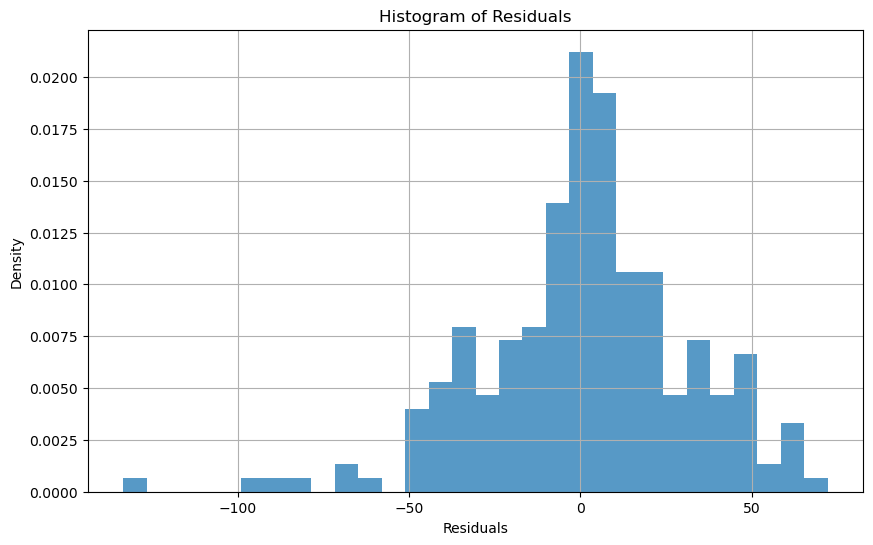

In [53]:
# Visualizng Histogram of residuals

plt.figure(figsize=(10, 6))
plt.hist(sarimax_residuals, bins=30, density=True, alpha=0.75)
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.grid(True)
plt.show()

In [54]:
# Make Predictions
sarimax_train_predict = sarimax_model.predict(start=train.index[0], end=train.index[-1])
sarimax_test_predict = sarimax_model.predict(start=test.index[0], end=test.index[-1])

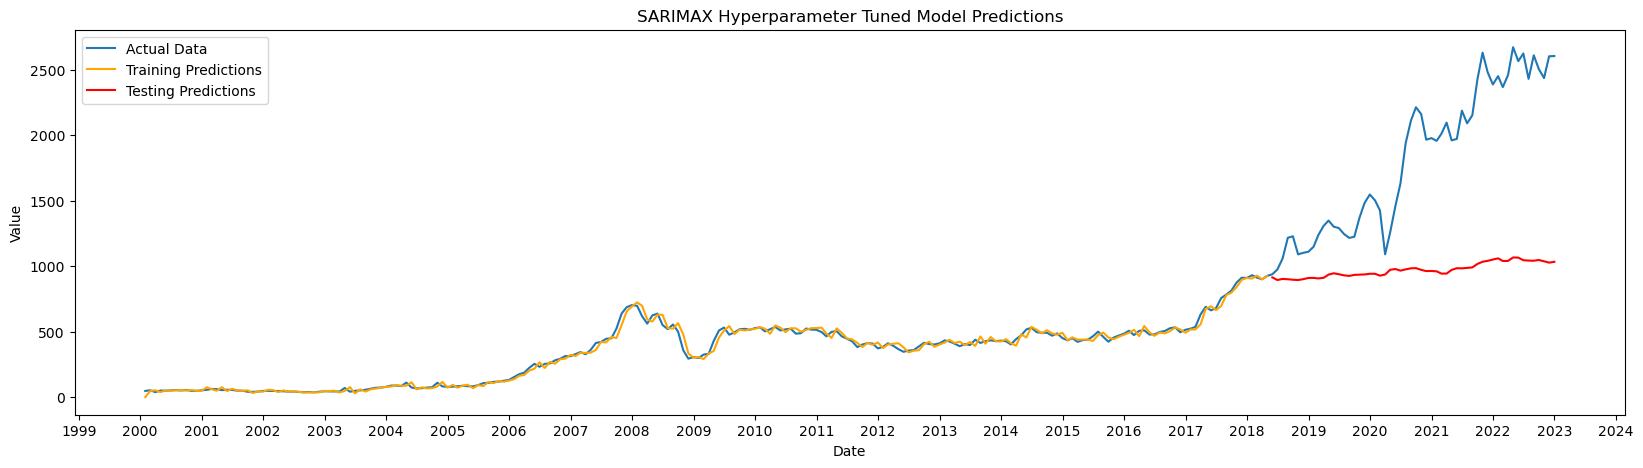

In [55]:
# Plot training and test data along with predictions
plt.figure(figsize=(20, 5))

# Plot actual data
plt.plot(monthly_df.index, monthly_df['Close'], label='Actual Data')

# Plot in-sample predictions
plt.plot(sarimax_train_predict.index, train_predict, label='Training Predictions', color='orange')

# Plot out-of-sample predictions
plt.plot(sarimax_test_predict.index, test_predict, label='Testing Predictions', color='red')

plt.xlabel('Date')
plt.ylabel('Value')
plt.title('SARIMAX Hyperparameter Tuned Model Predictions')
plt.legend()
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.show()

#### Making Forecasts

In [56]:
# Forecast period from the end of available data
start = len(monthly_df)
 
# and it will end 36 months later
end = (len(monthly_df) - 1) + 3*12
 
# Build a forecast for three years ahead (2023-2026)
sarimax_forecasts = sarimax_model.predict(start, end)

# Convert predictions to DataFrame for easier handling
sarimax_forecasts_df = pd.Series(sarimax_forecasts, index=sarimax_forecasts.index)

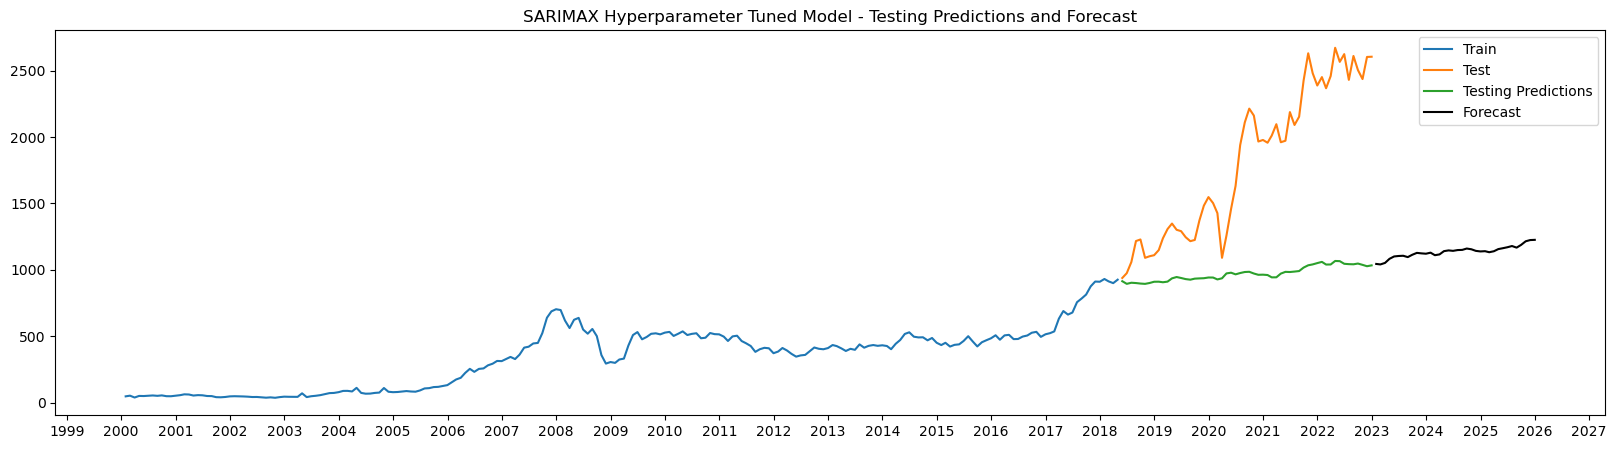

In [57]:
# Plotting forecast

plt.figure(figsize=(20, 5))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(predictions.index, predictions, label="Testing Predictions")
plt.plot(forecasts_df.index, forecasts_df, label='Forecast', color='black')
plt.title('SARIMAX Hyperparameter Tuned Model - Testing Predictions and Forecast')
plt.legend()
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.show()

#### Comparing Normal and Hyperparameter-Tuned Model

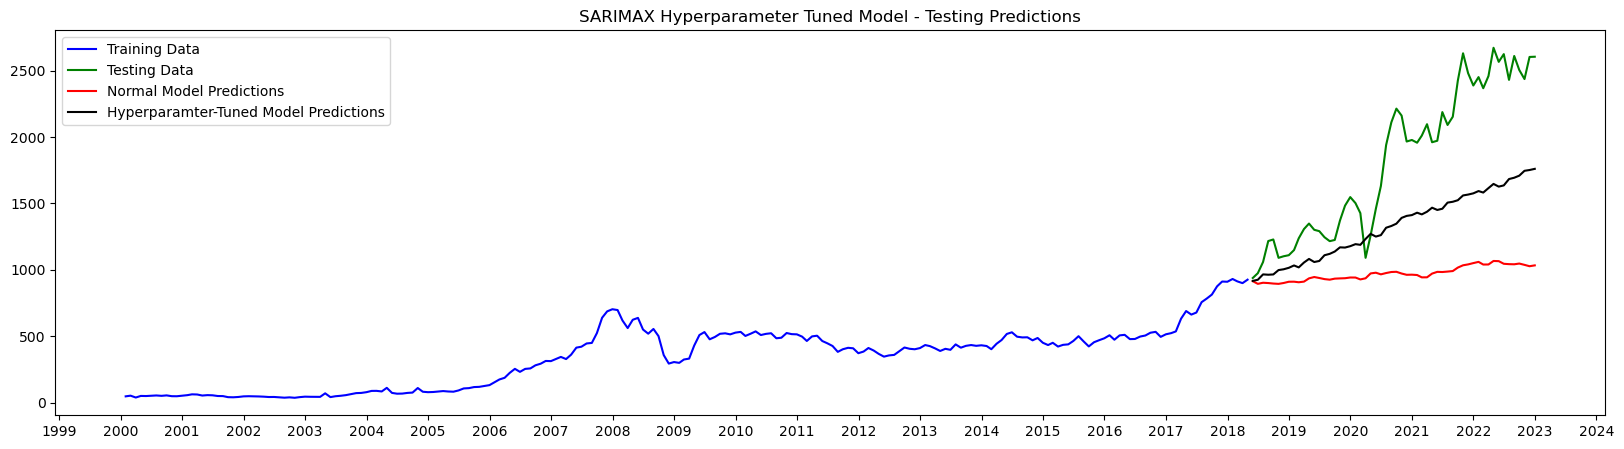

In [58]:
# Plotting Predictions

plt.figure(figsize=(20, 5))
plt.plot(train.index, train, label='Training Data', color='blue')
plt.plot(test.index, test, label='Testing Data', color='green')
plt.plot(predictions.index, predictions, label="Normal Model Predictions", color='red')
plt.plot(sarimax_predictions.index, sarimax_predictions, label='Hyperparamter-Tuned Model Predictions', color='black')
plt.title('SARIMAX Hyperparameter Tuned Model - Testing Predictions')
plt.legend()
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.show()

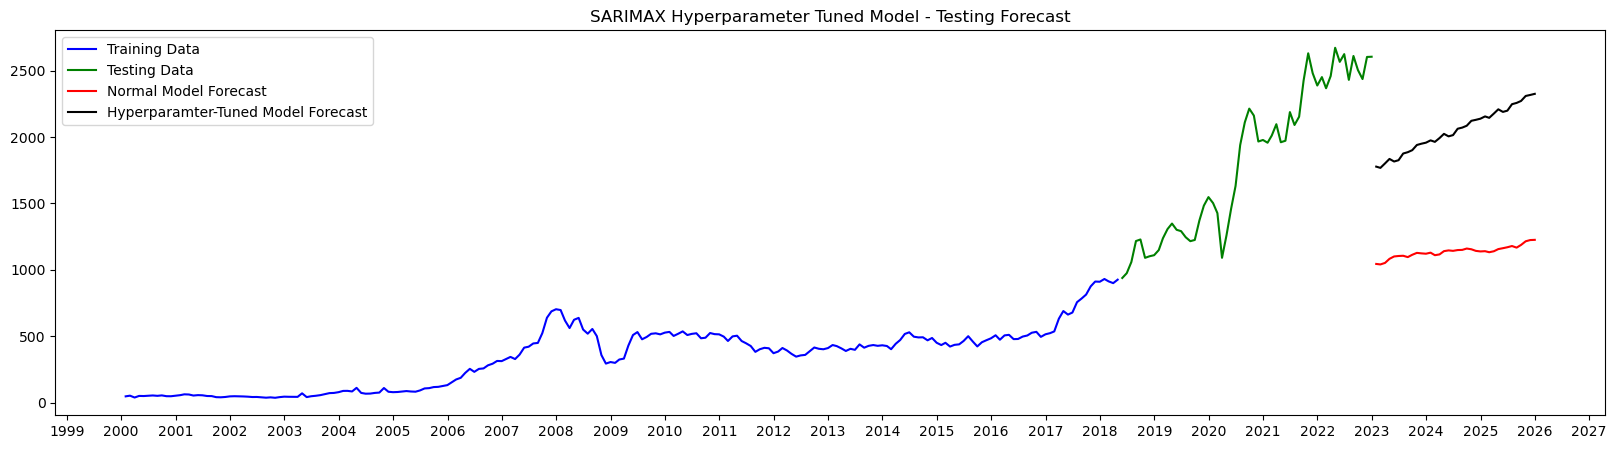

In [59]:
# Plotting Predictions

plt.figure(figsize=(20, 5))
plt.plot(train.index, train, label='Training Data', color='blue')
plt.plot(test.index, test, label='Testing Data', color='green')
plt.plot(forecasts_df.index, forecasts_df, label="Normal Model Forecast", color='red')
plt.plot(sarimax_forecasts_df.index, sarimax_forecasts_df, label='Hyperparamter-Tuned Model Forecast', color='black')
plt.title('SARIMAX Hyperparameter Tuned Model - Testing Forecast')
plt.legend()
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.show()

Based on the above graphs, we can see that the Hyperparameter-Tuned Model has better performance.

## Model Fitting - LSTM

In [60]:
# Copy dataset containing only 'Date' and 'Close' columns
df_lstm = df[['Close']]
df_lstm

,Close
Date,
2000-01-03,38.944569
2000-01-04,42.062302
2000-01-05,43.710136
2000-01-06,45.543640
2000-01-07,48.669109
...,...
2022-12-26,2524.050049
2022-12-27,2544.699951
2022-12-28,2544.449951


In [61]:
# Scaling data using MinMax Scaler since LSTM is sensitive to the scale of data

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_df = scaler.fit_transform(np.array(df_lstm).reshape(-1,1))

In [62]:
# Split dataset into training and testing (80% train, 20% test)

train_size = int(len(scaled_df) * 0.8)
train, test = scaled_df[:train_size], scaled_df[train_size:]

In [63]:
# Get training and testing dataset shape

print("Training Dataset Shape:", train.shape)
print("Testing Dataset Shape:", test.shape)

Training Dataset Shape: (4604, 1)
Testing Dataset Shape: (1151, 1)


In [64]:
# Define a Function to Create Datasets

def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step-1):
        a = dataset[i:(i+time_step),0]
        dataX.append(a)
        dataY.append(dataset[i+time_step,0])
    return np.array(dataX), np.array(dataY)

In [65]:
# Create datasets for training and testing

time_step = 50 # Number of time steps to look back
X_train, y_train = create_dataset(train, time_step)
X_test, y_test = create_dataset(test, time_step)

In [66]:
print(X_train.shape), print(y_train.shape)

(4553, 50)
(4553,)


(None, None)

In [67]:
print(X_test.shape), print(y_test.shape)

(1100, 50)
(1100,)


(None, None)

In [68]:
# Reshape training and testing data into 3D for LSTM

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print(X_train.shape), print(y_train.shape)

(4553, 50, 1)
(4553,)


(None, None)

In [78]:
# Set look_back value

look_back = 50

In [104]:
# Creating a Function to create the LSTM model

def create_model(units=50, activation='relu', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(units=units, return_sequences=True, input_shape=(look_back, 1)))
    model.add(LSTM(units=units, return_sequences=True))
    model.add(Dense(25, activation=activation))
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

In [105]:
# Wrapping the model using the function

model = KerasRegressor(build_fn=create_model, verbose=1)

# Defining the hyperparameters grid to search
param_grid={
    'model__units': [50, 100, 150],
    'model__activation': ['relu', 'tanh'],
    'model__optimizer': ['adam', 'rmsprop'],
    'batch_size': [32, 64],
    'epochs': [10, 20, 30]
}

In [106]:
# Create RandomizedSearchCV object
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_grid,
    n_iter=5,  # Number of parameter settings to sample
    cv=3,  # Number of cross-validation folds
    verbose=2
)

In [107]:
# Fit the RandomizedSearchCV model
random_search_result = random_search.fit(X_train, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
Epoch 1/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 13s 199ms/step - loss: 0.0093
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 10s 199ms/step - loss: 0.0029
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 175ms/step - loss: 0.0027
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 11s 190ms/step - loss: 0.0030
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 191ms/step - loss: 0.0030
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 179ms/step - loss: 0.0029
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 11s 187ms/step - loss: 0.0029
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 11s 200ms/step - loss: 0.0029
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 10s 184ms/step - loss: 0.0027
Epoch 10/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 10s 179ms/step - loss: 0.0028
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step
[CV] END batch_size=64, epochs=10, model__activation=relu, model__optimizer=adam, model__units=150; total time= 1.7min
Epoch 1/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 14s 182ms/step - loss: 0.0099
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━

In [108]:
# Printing the parameter settings that gave the best results

print(" Results from Random Search :" )
print("\n The best estimator across ALL searched params:\n", random_search_result.best_estimator_)
print("\n The best score across ALL searched params:\n", random_search_result.best_score_)
print("\n The best parameters across ALL searched params:\n", random_search_result.best_params_)

 Results from Random Search :

 The best estimator across ALL searched params:
 KerasRegressor(
	model=None
	build_fn=<function create_model at 0x000002886F4F8400>
	warm_start=False
	random_state=None
	optimizer=rmsprop
	loss=None
	metrics=None
	batch_size=64
	validation_batch_size=None
	verbose=1
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=10
	model__units=150
	model__optimizer=adam
	model__activation=relu
)

 The best score across ALL searched params:
 nan

 The best parameters across ALL searched params:
 {'model__units': 150, 'model__optimizer': 'adam', 'model__activation': 'relu', 'epochs': 10, 'batch_size': 64}


Now that we have the best parameters for the model, we will use those to train the model to give best accuracy.

#### Training Model with Best Parameters

In [109]:
# Define the LSTM model

def create_lstm_model(units=150, activation='relu', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(units=units, activation=activation, input_shape=(time_step, 1)))
    model.add(Dense(1))  # Assuming a regression task with a single output

    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    return model

# Parameters
units = 150
activation = 'relu'
optimizer = Adam()

# Create the model
lstm_model = create_lstm_model(units=units, activation=activation, optimizer=optimizer)

# Print the model summary to verify
lstm_model.summary()

Model: "sequential_34"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_68 (LSTM)                  │ (None, 150)            │        91,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_66 (Dense)                │ (None, 1)              │           151 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 91,351 (356.84 KB)

 Trainable params: 91,351 (356.84 KB)

 Non-trainable params: 0 (0.00 B)

In [110]:
# Early_stopping to prevent model overfitting. Monitor the validation loss and stop training when performance starts to degrade.

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [111]:
# Train the Model

lstm_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=64, verbose=1)

Epoch 1/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 10s 103ms/step - loss: 0.0055 - val_loss: 0.0404
Epoch 2/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 9s 75ms/step - loss: 6.0100e-05 - val_loss: 0.0066
Epoch 3/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 11s 84ms/step - loss: 8.0933e-05 - val_loss: 0.0031
Epoch 4/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - loss: 7.9131e-05 - val_loss: 0.0038
Epoch 5/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - loss: 1.0164e-04 - val_loss: 0.0021
Epoch 6/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - loss: 6.3071e-05 - val_loss: 7.6700e-04
Epoch 7/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - loss: 8.7569e-05 - val_loss: 0.0014
Epoch 8/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 6.5498e-05 - val_loss: 0.0010
Epoch 9/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 10s 87ms/step - loss: 6.0527e-05 - val_loss: 6.8822e-04
Epoch 10/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - loss: 7.3077e-05 - val_loss: 7.6380e-04


In [112]:
# Make Predictions

lstm_train_predict = lstm_model.predict(X_train)
lstm_test_predict = lstm_model.predict(X_test)

143/143 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


In [113]:
# Inverse Transform Predictions

lstm_train_predict = scaler.inverse_transform(lstm_train_predict)
lstm_test_predict = scaler.inverse_transform(lstm_test_predict)

In [114]:
# Calculate Performance Metrics

print("----------------Evaluation Metrics for Training Data-------------------")
print(f'Root Mean Squared Error: {math.sqrt(mean_squared_error(y_train,lstm_train_predict))}')
print(f'Mean Squared Error: {mean_squared_error(y_train,lstm_train_predict)}')
print(f'Mean Absolute Error: {mean_absolute_error(y_train,lstm_train_predict)}')
print(f'R2 Score: {r2_score(y_train, lstm_train_predict)}')
print("\n----------------Evaluation Metrics for Testing Data-------------------")
print(f'Root Mean Squared Error: {math.sqrt(mean_squared_error(y_test,lstm_test_predict))}')
print(f'Mean Squared Error: {mean_squared_error(y_test,lstm_test_predict)}')
print(f'Mean Absolute Error: {mean_absolute_error(y_test,lstm_test_predict)}')
print(f'R2 Score: {r2_score(y_test, lstm_test_predict)}')

----------------Evaluation Metrics for Training Data-------------------
Root Mean Squared Error: 418.20169993859423
Mean Squared Error: 174892.66183153001
Mean Absolute Error: 350.3074663106312
R2 Score: -25435564.12763697

----------------Evaluation Metrics for Testing Data-------------------
Root Mean Squared Error: 1969.1312396354856
Mean Squared Error: 3877477.8389083846
Mean Absolute Error: 1884.4552308554635
R2 Score: -101265518.50958033


In [115]:
# Creating a new DataFrame to hold the results for plotting
plot_data_lstm = df[['Close']]
plot_data_lstm

,Close
Date,
2000-01-03,38.944569
2000-01-04,42.062302
2000-01-05,43.710136
2000-01-06,45.543640
2000-01-07,48.669109
...,...
2022-12-26,2524.050049
2022-12-27,2544.699951
2022-12-28,2544.449951


In [116]:
# Add columns to the DataFrame for the training and test predictions
plot_data_lstm['Train_Predict'] = np.nan
plot_data_lstm['Test_Predict'] = np.nan

In [117]:
# Lengths of train and test predictions
train_len = len(lstm_train_predict)
test_len = len(lstm_test_predict)

In [118]:
# Assign the predictions to the appropriate locations in the DataFrame

plot_data_lstm['Train_Predict'].iloc[look_back:look_back+train_len] = lstm_train_predict.flatten()
plot_data_lstm['Test_Predict'].iloc[look_back+train_len+1:look_back+train_len+1+test_len] = lstm_test_predict.flatten()

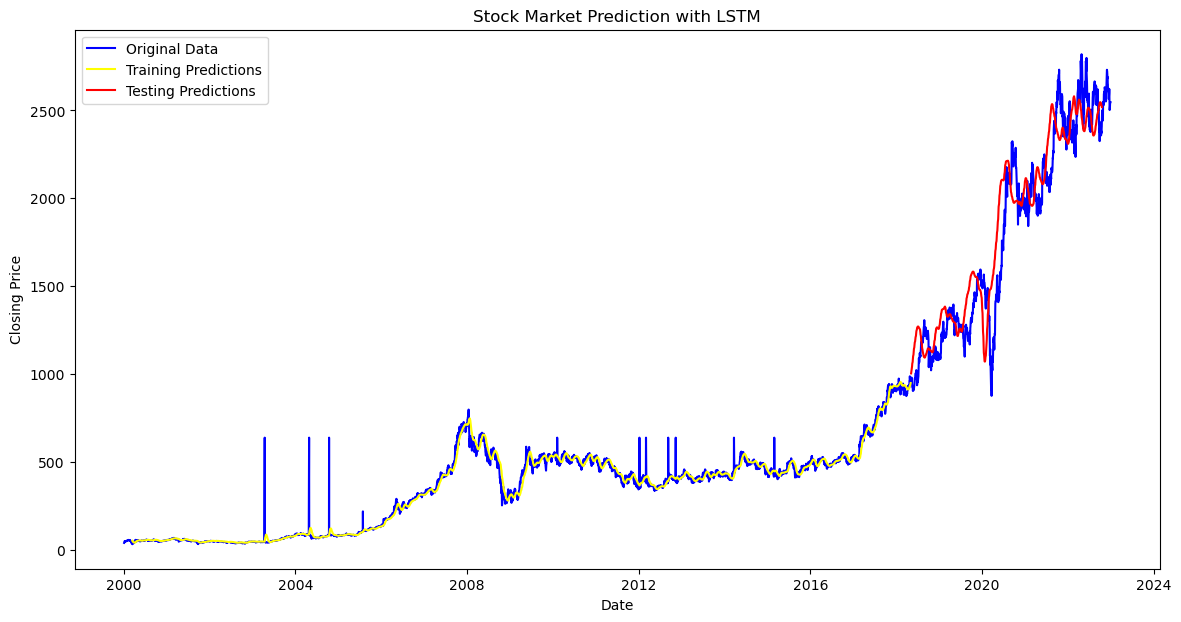

In [119]:
# Plot the original data and the predictions
plt.figure(figsize=(14, 7))

# Plot original data
plt.plot(plot_data_lstm.index, plot_data_lstm['Close'], label='Original Data', color='blue')

# Plot training predictions
plt.plot(plot_data_lstm.index, plot_data_lstm['Train_Predict'], label='Training Predictions', color='yellow')

# Plot testing predictions
plt.plot(plot_data_lstm.index, plot_data_lstm['Test_Predict'], label='Testing Predictions', color='red')

plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Stock Market Prediction with LSTM')
plt.legend()
plt.show()

#### Making Forecasts

In [120]:
# Define function to forecast next n days
def forecast_next_days(model, data, n_days, look_back):
    forecast = []
    last_sequence = data[-look_back:]
    current_sequence = np.reshape(last_sequence, (1, look_back, 1))

    for _ in range(n_days):
        next_value = model.predict(current_sequence)
        forecast.append(next_value[0, 0])
        current_sequence = np.append(current_sequence[:, 1:, :], next_value.reshape(1, 1, 1), axis=1)

    return np.array(forecast)

In [121]:
# Number of days to forecast
n_days = 30

# Getting the last look_back days from the dataset
last_sequence = scaled_df[-look_back:]

# Forecasting next 30 days
lstm_forecasted_values = forecast_next_days(lstm_model, scaled_df, n_days, look_back)

# Invertint the scaled predictions back to the original scale
lstm_forecasted_values = scaler.inverse_transform(lstm_forecasted_values.reshape(-1,1))

# Creating a Dataframe for plotting
lstm_forecast_dates = pd.date_range(
    start=df.index[-1] + pd.Timedelta(days=1),
    periods=n_days,
    freq='B'
)

lstm_forecast_df = pd.DataFrame(
    lstm_forecasted_values,
    index=lstm_forecast_dates,
    columns=['Forecast']
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━

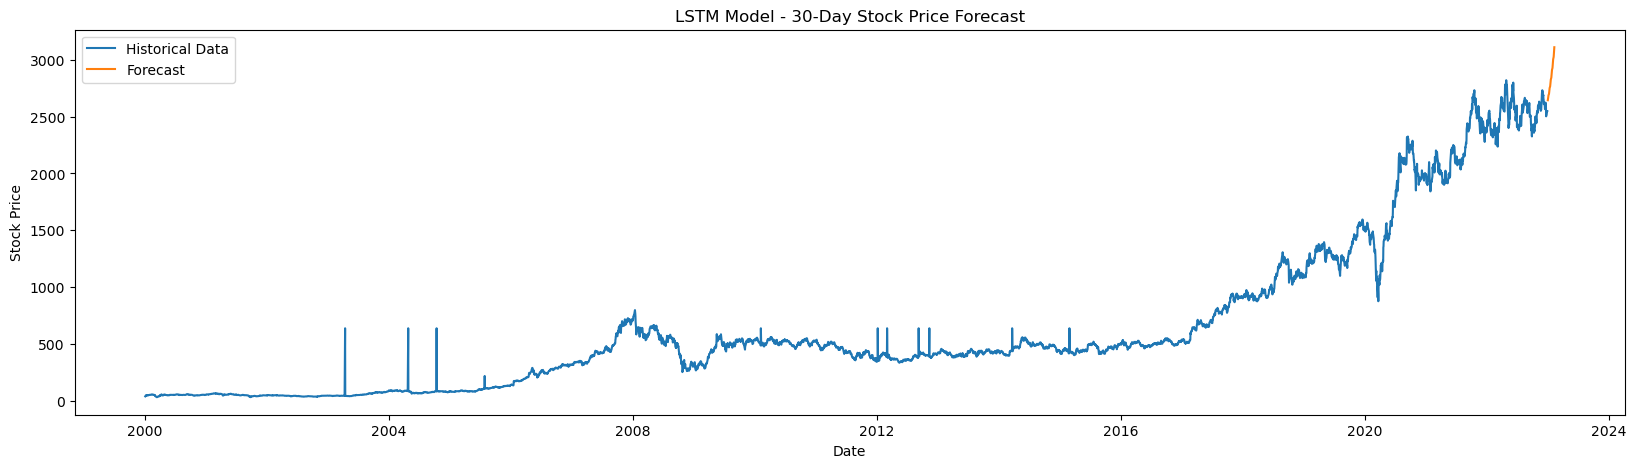

In [122]:
# Plotting the results
plt.figure(figsize=(20, 5))
plt.plot(df['Close'], label='Historical Data')
plt.plot(lstm_forecast_df, label='Forecast')
plt.title('LSTM Model - 30-Day Stock Price Forecast')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

## Model Fitting - GRU

In [156]:
# Copy dataset containing only 'Date' and 'Close' columns
df_gru = df[['Close']]
df_gru

,Close
Date,
2000-01-03,38.944569
2000-01-04,42.062302
2000-01-05,43.710136
2000-01-06,45.543640
2000-01-07,48.669109
...,...
2022-12-26,2524.050049
2022-12-27,2544.699951
2022-12-28,2544.449951


In [157]:
# Normalize the data

scaler = StandardScaler()
scaled_df = scaler.fit_transform(df_gru)

In [158]:
# Split dataset into training and testing (80% train, 20% test)

train_size = int(len(scaled_df) * 0.8)
train, test = scaled_df[:train_size], scaled_df[train_size:]

In [159]:
# Get training and testing dataset shape

print("Training Dataset Shape:", train.shape)
print("Testing Dataset Shape:", test.shape)

Training Dataset Shape: (4604, 1)
Testing Dataset Shape: (1151, 1)


In [160]:
# Define a Function to Create Datasets

def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step-1):
        a = dataset[i:(i+time_step),0]
        dataX.append(a)
        dataY.append(dataset[i+time_step,0])
    return np.array(dataX), np.array(dataY)

In [161]:
# Create datasets for training and testing

time_step = 50 # Number of time steps to look back
X_train, y_train = create_dataset(train, time_step)
X_test, y_test = create_dataset(test, time_step)

In [162]:
print(X_train.shape), print(y_train.shape)

(4553, 50)
(4553,)


(None, None)

In [163]:
print(X_test.shape), print(y_test.shape)

(1100, 50)
(1100,)


(None, None)

In [166]:
# Reshape the data
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_train.shape)

(4553, 50, 1)


In [176]:
# Set look_back value 

look_back = 50

In [208]:
def create_model(units=50, activation='relu', optimizer='adam'):
    model = Sequential()
    model.add(GRU(units=50, return_sequences=True, input_shape=(time_step, 1)))
    model.add(Dropout(0.2))
    model.add(GRU(units=50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

In [209]:
# Wrapping the model using the function

gru_model = KerasRegressor(build_fn=create_model, verbose=1)

# Defining the hyperparameters grid to search
param_grid={
    'model__units': [50, 100, 150],
    'model__activation': ['relu', 'tanh'],
    'model__optimizer': ['adam', 'rmsprop'],
    'batch_size': [32, 64],
    'epochs': [10, 20, 30]
}

In [210]:
# Create RandomizedSearchCV object
random_search = RandomizedSearchCV(
    estimator=gru_model,
    param_distributions=param_grid,
    n_iter=5,  # Number of parameter settings to sample
    cv=3,  # Number of cross-validation folds
    verbose=2
)

In [211]:
# Fit the RandomizedSearchCV model
random_search_result = random_search.fit(X_train, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
Epoch 1/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 10s 95ms/step - loss: 0.0334
Epoch 2/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 98ms/step - loss: 0.0021
Epoch 3/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 99ms/step - loss: 0.0017
Epoch 4/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 108ms/step - loss: 0.0017
Epoch 5/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 100ms/step - loss: 0.0016
Epoch 6/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 98ms/step - loss: 0.0015
Epoch 7/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 101ms/step - loss: 0.0016
Epoch 8/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 98ms/step - loss: 0.0014
Epoch 9/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 99ms/step - loss: 0.0013
Epoch 10/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 89ms/step - loss: 0.0015
Epoch 11/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 100ms/step - loss: 0.0014
Epoch 12/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 99ms/step - loss: 0.0013
Epoch 13/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 103ms/step - loss: 0.0014
Epoch 14/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 99ms/step - loss: 0.0013 
Epoc

In [212]:
# Printing the parameter settings that gave the best results

print(" Results from Random Search :" )
print("\n The best estimator across ALL searched params:\n", random_search_result.best_estimator_)
print("\n The best score across ALL searched params:\n", random_search_result.best_score_)
print("\n The best parameters across ALL searched params:\n", random_search_result.best_params_)

 Results from Random Search :

 The best estimator across ALL searched params:
 KerasRegressor(
	model=None
	build_fn=<function create_model at 0x00000288DA6C6660>
	warm_start=False
	random_state=None
	optimizer=rmsprop
	loss=None
	metrics=None
	batch_size=64
	validation_batch_size=None
	verbose=1
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=30
	model__units=100
	model__optimizer=adam
	model__activation=tanh
)

 The best score across ALL searched params:
 0.787063143543017

 The best parameters across ALL searched params:
 {'model__units': 100, 'model__optimizer': 'adam', 'model__activation': 'tanh', 'epochs': 30, 'batch_size': 64}


Now that we have the best parameters for the model, we will use those to train the model to give best accuracy.

#### Training Model with Best Parameters

In [213]:
# Parameters
units = 100
activation = 'tanh'
optimizer = Adam()

# Create the model
gru_model = create_model(units=units, activation=activation, optimizer=optimizer)

# Print the model summary to verify
gru_model.summary()

Model: "sequential_71"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_72 (GRU)                    │ (None, 50, 50)         │         7,950 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_72 (Dropout)            │ (None, 50, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_73 (GRU)                    │ (None, 50)             │        15,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_73 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_103 (Dense)               │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,301 (91.02 KB)

 Trainable params: 23,301 (91.02 KB)

 Non-trainable params: 0 (0.00 B)

In [214]:
# Early_stopping to prevent model overfitting. Monitor the validation loss and stop training when performance starts to degrade.

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [215]:
# Train the Model

gru_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=30, batch_size=64, verbose=1)

Epoch 1/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 11s 78ms/step - loss: 0.0357 - val_loss: 0.0587
Epoch 2/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - loss: 0.0045 - val_loss: 0.0640
Epoch 3/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - loss: 0.0043 - val_loss: 0.0547
Epoch 4/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 5s 75ms/step - loss: 0.0041 - val_loss: 0.0515
Epoch 5/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 6s 78ms/step - loss: 0.0033 - val_loss: 0.0700
Epoch 6/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - loss: 0.0037 - val_loss: 0.0699
Epoch 7/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - loss: 0.0032 - val_loss: 0.0472
Epoch 8/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - loss: 0.0026 - val_loss: 0.0294
Epoch 9/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - loss: 0.0030 - val_loss: 0.0493
Epoch 10/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - loss: 0.0027 - val_loss: 0.0462
Epoch 11/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 6s 78ms/step - loss: 0.0025 - val_loss: 0.0527
Epoch 12/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - loss: 0.

In [216]:
# Make Predictions

gru_train_predict = gru_model.predict(X_train)
gru_test_predict = gru_model.predict(X_test)

143/143 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step


In [217]:
# Inverse Transform Predictions

gru_train_predict = scaler.inverse_transform(gru_train_predict)
gru_test_predict = scaler.inverse_transform(gru_test_predict)

In [218]:
# Calculate Performance Metrics

print("----------------Evaluation Metrics for Training Data-------------------")
print(f'Root Mean Squared Error: {math.sqrt(mean_squared_error(y_train,gru_train_predict))}')
print(f'Mean Squared Error: {mean_squared_error(y_train,gru_train_predict)}')
print(f'Mean Absolute Error: {mean_absolute_error(y_train,gru_train_predict)}')
print(f'R2 Score: {r2_score(y_train, gru_train_predict)}')
print("\n----------------Evaluation Metrics for Testing Data-------------------")
print(f'Root Mean Squared Error: {math.sqrt(mean_squared_error(y_test,gru_test_predict))}')
print(f'Mean Squared Error: {mean_squared_error(y_test,gru_test_predict)}')
print(f'Mean Absolute Error: {mean_absolute_error(y_test,gru_test_predict)}')
print(f'R2 Score: {r2_score(y_test, gru_test_predict)}')

----------------Evaluation Metrics for Training Data-------------------
Root Mean Squared Error: 409.85892484507497
Mean Squared Error: 167984.33827516082
Mean Absolute Error: 334.3073156085567
R2 Score: -1446917.0001185583

----------------Evaluation Metrics for Testing Data-------------------
Root Mean Squared Error: 1851.0636198724821
Mean Squared Error: 3426436.5248154174
Mean Absolute Error: 1790.296079406889
R2 Score: -5299808.807733832


In [219]:
# Creating a new DataFrame to hold the results for plotting
plot_data_gru = df[['Close']]
plot_data_gru

,Close
Date,
2000-01-03,38.944569
2000-01-04,42.062302
2000-01-05,43.710136
2000-01-06,45.543640
2000-01-07,48.669109
...,...
2022-12-26,2524.050049
2022-12-27,2544.699951
2022-12-28,2544.449951


In [220]:
# Add columns to the DataFrame for the training and test predictions
plot_data_gru['Train_Predict'] = np.nan
plot_data_gru['Test_Predict'] = np.nan

In [221]:
# Lengths of train and test predictions
train_len = len(gru_train_predict)
test_len = len(gru_test_predict)

In [222]:
# Assign the predictions to the appropriate locations in the DataFrame
look_back = 50
plot_data_gru['Train_Predict'].iloc[look_back:look_back+train_len] = gru_train_predict.flatten()
plot_data_gru['Test_Predict'].iloc[look_back+train_len+1:look_back+train_len+1+test_len] = gru_test_predict.flatten()

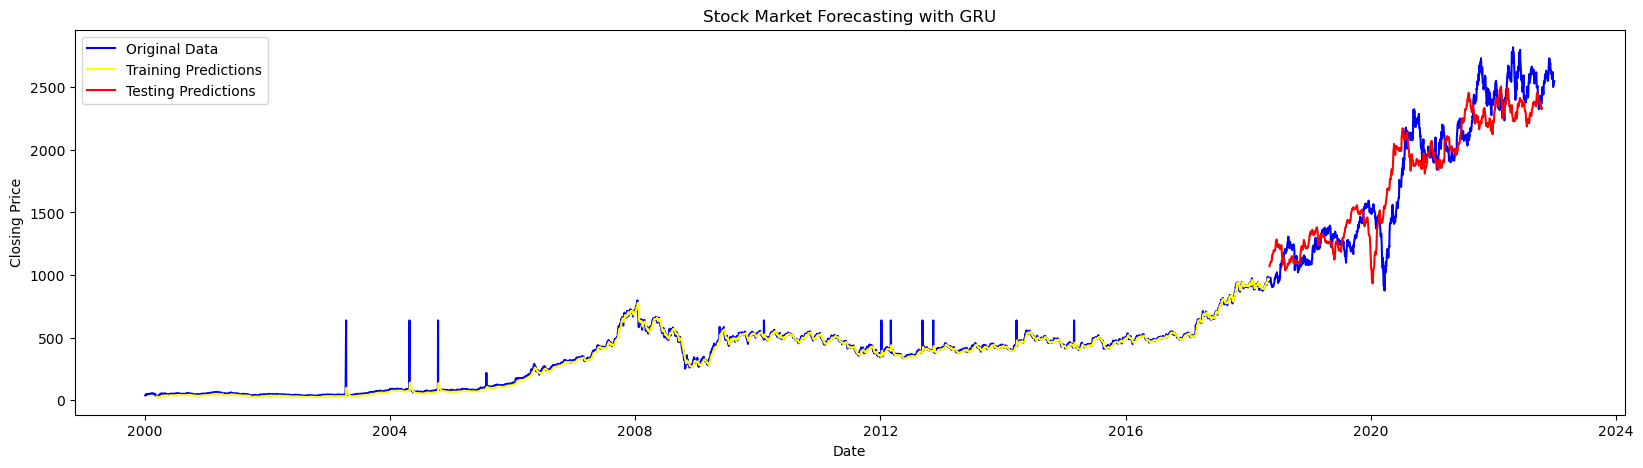

In [223]:
# Plot the original data and the predictions
plt.figure(figsize=(20, 5))

# Plot original data
plt.plot(plot_data_gru.index, plot_data['Close'], label='Original Data', color='blue')

# Plot training predictions
plt.plot(plot_data_gru.index, plot_data['Train_Predict'], label='Training Predictions', color='yellow')

# Plot testing predictions
plt.plot(plot_data_gru.index, plot_data['Test_Predict'], label='Testing Predictions', color='red')

plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Stock Market Forecasting with GRU')
plt.legend()
plt.show()

#### Making Forecasts

In [224]:
# Define function to forecast next n days
def forecast_next_days(model, data, n_days, look_back):
    forecast = []
    last_sequence = data[-look_back:]
    current_sequence = np.reshape(last_sequence, (1, look_back, 1))

    for _ in range(n_days):
        next_value = model.predict(current_sequence)
        forecast.append(next_value[0, 0])
        current_sequence = np.append(current_sequence[:, 1:, :], next_value.reshape(1, 1, 1), axis=1)

    return np.array(forecast)

In [225]:
# Number of days to forecast
n_days = 30

# Getting the last look_back days from the dataset
last_sequence = scaled_df[-look_back:]

# Forecasting next 30 days
gru_forecasted_values = forecast_next_days(gru_model, scaled_df, n_days, look_back)

# Invertint the scaled predictions back to the original scale
gru_forecasted_values = scaler.inverse_transform(gru_forecasted_values.reshape(-1,1))

# Creating a Dataframe for plotting
gru_forecast_dates = pd.date_range(
    start=df.index[-1] + pd.Timedelta(days=1),
    periods=n_days,
    freq='B'
)

gru_forecast_df = pd.DataFrame(
    gru_forecasted_values,
    index=gru_forecast_dates,
    columns=['Forecast']
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━

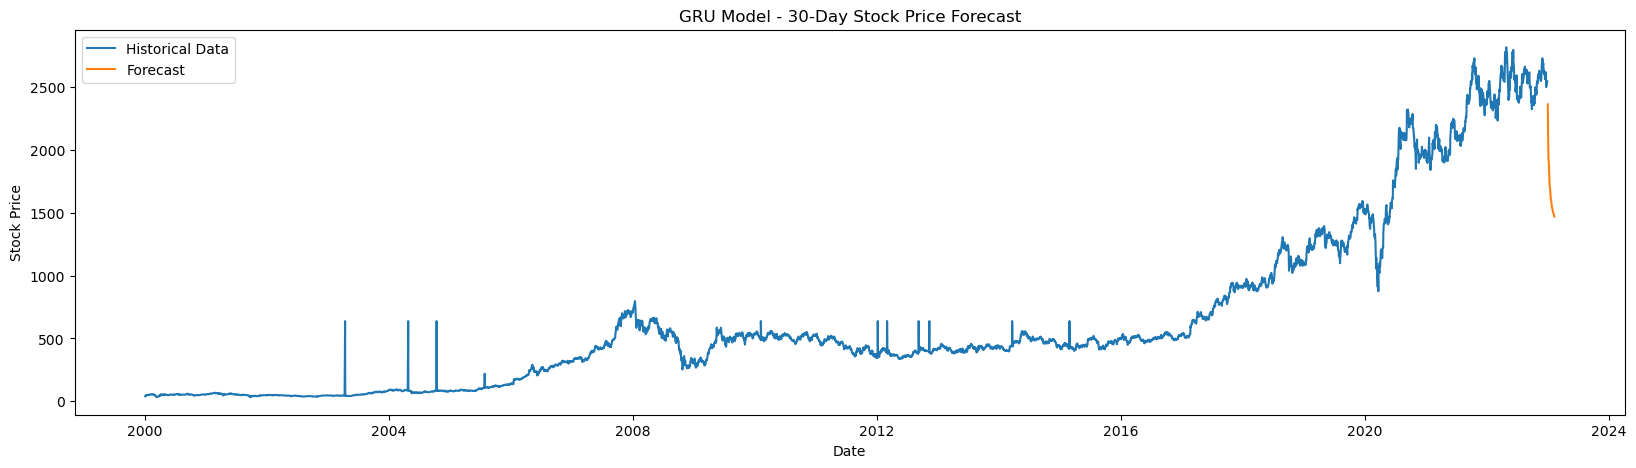

In [226]:
# Plotting the results
plt.figure(figsize=(20, 5))
plt.plot(df['Close'], label='Historical Data')
plt.plot(gru_forecast_df, label='Forecast')
plt.title('GRU Model - 30-Day Stock Price Forecast')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

### Model Comparison

In [ ]:
# Split dataset into training and testing (80% train, 20% test)

train_size = int(len(monthly_df) * 0.8)
train, test = monthly_df[:train_size], monthly_df[train_size:]

In [ ]:
# Resampling the Predictions dataset from daily to monthly for LSTM and GRU for visualization

plot_data_lstm_monthly = plot_data_lstm.copy()
plot_data_lstm_monthly = plot_data_lstm_monthly.resample('M').mean()

plot_data_gru_monthly = plot_data_gru.copy()
plot_data_gru_monthly = plot_data_gru_monthly.resample('M').mean()

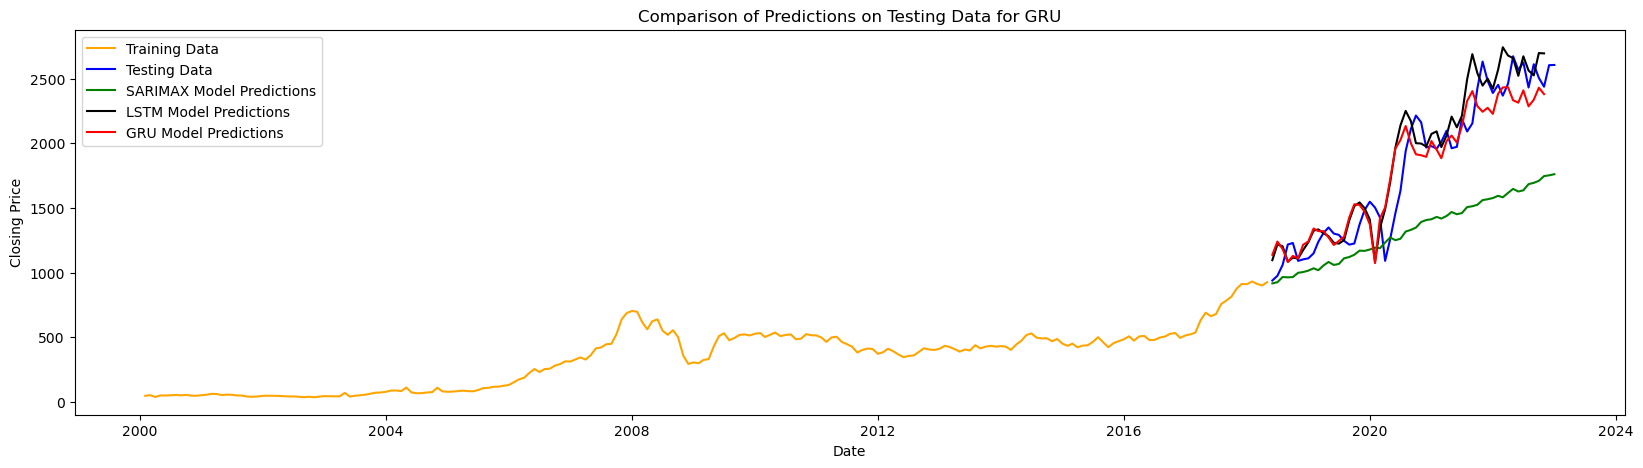

In [231]:
# Visualizing Comparison of Testing Predictions by all Models

plt.figure(figsize=(20, 5))

# Plot training data
plt.plot(train.index, train['Close'], label='Training Data', color='orange')

# Plot testing data
plt.plot(test.index, test['Close'], label='Testing Data', color='blue')

# Plot testing predictions for SARIMAX model
plt.plot(sarimax_predictions.index, sarimax_predictions, label='SARIMAX Model Predictions', color='green')

# Plot testing predictions for LSTM model
plt.plot(plot_data_lstm_monthly.index, plot_data_lstm_monthly['Test_Predict'], label='LSTM Model Predictions', color='black')

# Plot testing predictions for GRU model
plt.plot(plot_data_gru_monthly.index, plot_data_gru_monthly['Test_Predict'], label='GRU Model Predictions', color='red')

plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Comparison of Predictions on Testing Data for GRU')
plt.legend()
plt.show()

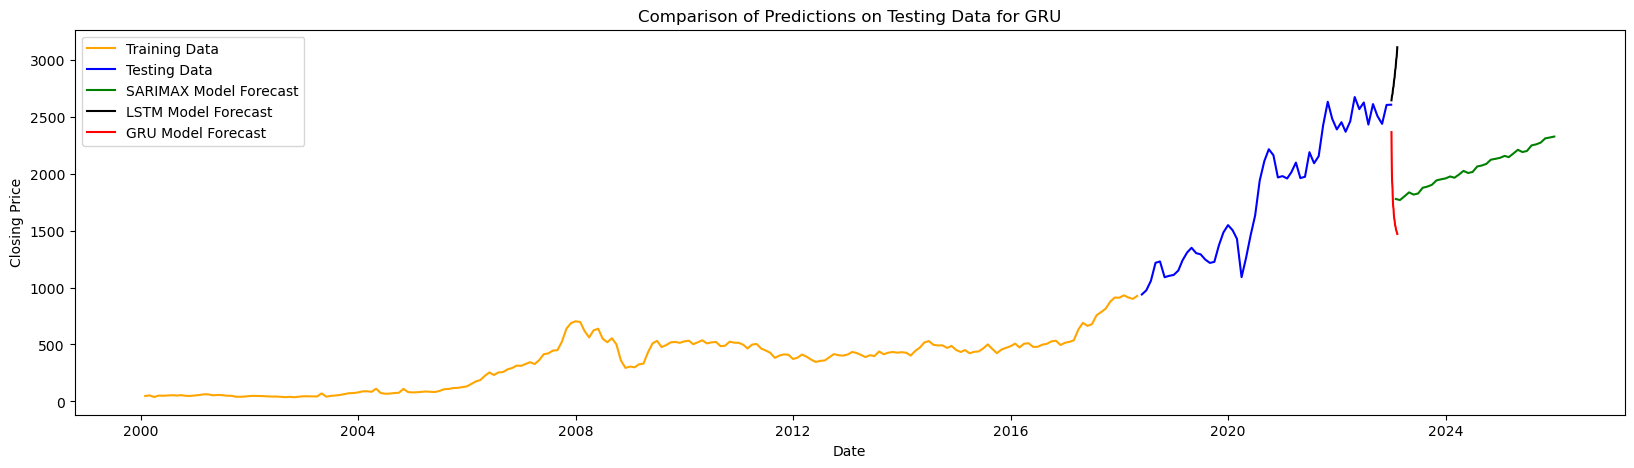

In [232]:
# Visualizing Comparison of Forecasts by all Models

plt.figure(figsize=(20, 5))

# Plot training data
plt.plot(train.index, train['Close'], label='Training Data', color='orange')

# Plot testing data
plt.plot(test.index, test['Close'], label='Testing Data', color='blue')

# Plot testing predictions for SARIMAX model
plt.plot(sarimax_forecasts.index, sarimax_forecasts, label='SARIMAX Model Forecast', color='green')

# Plot testing predictions for LSTM model
plt.plot(lstm_forecast_df.index, lstm_forecast_df, label='LSTM Model Forecast', color='black')

# Plot testing predictions for GRU model
plt.plot(gru_forecast_df.index, gru_forecast_df, label='GRU Model Forecast', color='red')

plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Comparison of Forecasts on Testing Data for GRU')
plt.legend()
plt.show()

Based on these visualizations, we can see that the LSTM Model performed the best as compared to SARIMAX or GRU models.